In [1]:
# Core imports
from dataclasses import dataclass
from typing import List, Dict, Set, Tuple

import numpy as np
import networkx as nx

# ---------- Core logic-level circuit data structures ----------

@dataclass
class Node:
    """
    A node in a logic circuit DAG.
    name: unique string ID
    op:   "PI", "AND", "OR", "XOR", "NOT", etc.
    fanins: list of node names driving this node
    """
    name: str
    op: str
    fanins: List[str]


class Circuit:
    def __init__(self, name: str, k: int = 4):
        self.name = name
        self.k = k                 # max LUT size we’re targeting
        self.nodes: Dict[str, Node] = {}
        self.inputs: Set[str] = set()
        self.outputs: Set[str] = set()

    # --- add nodes ---

    def add_pi(self, name: str):
        """Add a primary input."""
        self.nodes[name] = Node(name=name, op="PI", fanins=[])
        self.inputs.add(name)

    def add_gate(self, name: str, op: str, fanins: List[str]):
        """Add an internal gate node."""
        self.nodes[name] = Node(name=name, op=op, fanins=list(fanins))

    def add_output(self, name: str):
        """Mark an existing node as a primary output."""
        assert name in self.nodes, f"Output {name} must be an existing node"
        self.outputs.add(name)

    # --- graph / topo utilities ---

    def to_nx(self) -> nx.DiGraph:
        """Convert to a NetworkX DAG for topo order, etc."""
        g = nx.DiGraph()
        for node in self.nodes.values():
            g.add_node(node.name, op=node.op)
            for fi in node.fanins:
                g.add_edge(fi, node.name)
        return g

    def topo_order(self) -> List[str]:
        """Topological order of node names."""
        return list(nx.topological_sort(self.to_nx()))

    def __repr__(self):
        return f"Circuit(name={self.name!r}, k={self.k}, nodes={len(self.nodes)})"


In [2]:
# ---------- Build a 1-bit full adder circuit ----------

def make_full_adder(k: int = 4) -> Circuit:
    """
    Construct a 1-bit full adder:
        inputs:  a, b, cin
        outputs: sum, cout

    Logic decomposition used:
        s1   = a XOR b
        sum  = s1 XOR cin

        c1   = a AND b
        c2   = a AND cin
        c3   = b AND cin

        t1   = c1 OR c2
        cout = t1 OR c3
    """
    c = Circuit(name="full_adder", k=k)

    # Primary inputs
    c.add_pi("a")
    c.add_pi("b")
    c.add_pi("cin")

    # Internal gates
    c.add_gate("s1",  "XOR", ["a", "b"])
    c.add_gate("sum", "XOR", ["s1", "cin"])

    c.add_gate("c1", "AND", ["a",   "b"])
    c.add_gate("c2", "AND", ["a",   "cin"])
    c.add_gate("c3", "AND", ["b",   "cin"])

    c.add_gate("t1",   "OR",  ["c1", "c2"])
    c.add_gate("cout", "OR",  ["t1", "c3"])

    # Mark outputs
    c.add_output("sum")
    c.add_output("cout")

    return c


# Quick sanity check
full_adder = make_full_adder()
print(full_adder)
print("Topo order:", full_adder.topo_order())

Circuit(name='full_adder', k=4, nodes=10)
Topo order: ['a', 'b', 'cin', 's1', 'c1', 'c2', 'c3', 'sum', 't1', 'cout']


In [3]:
# ---------- Truth table evaluation for a Circuit ----------

def eval_gate(op: str, fanin_vals: List[int]) -> int:
    """
    Evaluate a logic gate with Boolean inputs (0/1).
    Supports basic ops used in our circuit.
    """
    if op == "PI":
        raise ValueError("Primary inputs are not evaluated as gates.")

    if op == "NOT":
        assert len(fanin_vals) == 1
        return 0 if fanin_vals[0] == 1 else 1

    if op == "AND":
        out = 1
        for v in fanin_vals:
            out &= v
        return out

    if op == "OR":
        out = 0
        for v in fanin_vals:
            out |= v
        return out

    if op == "XOR":
        out = 0
        for v in fanin_vals:
            out ^= v
        return out

    raise ValueError(f"Unsupported gate op: {op}")


def evaluate_circuit(c: Circuit, input_assign: Dict[str, int]) -> Dict[str, int]:
    """
    Given a Circuit and a dictionary of primary input values {name: 0/1},
    compute the value at every node in topological order.
    
    Returns a dict mapping node_name -> 0/1.
    """
    values: Dict[str, int] = {}

    # Ensure we got all inputs
    for pi in c.inputs:
        assert pi in input_assign, f"Missing value for primary input {pi!r}"
        v = int(input_assign[pi])
        assert v in (0, 1), f"Input {pi!r} must be 0 or 1, got {v}"
        values[pi] = v

    # Evaluate internal nodes in topo order
    for name in c.topo_order():
        node = c.nodes[name]
        if node.op == "PI":
            # Already assigned
            continue

        fanin_vals = [values[fi] for fi in node.fanins]
        values[name] = eval_gate(node.op, fanin_vals)

    return values


def truth_table(c: Circuit):
    """
    Print the truth table for all primary inputs and outputs of the circuit.
    Returns a list of rows, each row = (input_dict, output_dict).
    """
    input_names = sorted(c.inputs)
    output_names = sorted(c.outputs)

    rows = []

    n = len(input_names)
    print("Truth table for", c.name)
    header = "  ".join(input_names) + "  |  " + "  ".join(output_names)
    print(header)
    print("-" * len(header))

    for pattern in range(2**n):
        # Build input assignment for this pattern
        bits = [(pattern >> i) & 1 for i in range(n)]
        # Match sorted input_names
        input_assign = {name: bits[i] for i, name in enumerate(input_names)}

        values = evaluate_circuit(c, input_assign)
        output_vals = {name: values[name] for name in output_names}

        # Print
        in_str = "  ".join(str(input_assign[name]) for name in input_names)
        out_str = "  ".join(str(output_vals[name]) for name in output_names)
        print(f"{in_str}  |  {out_str}")

        rows.append((input_assign, output_vals))

    return rows


# Quick sanity check on the full adder
rows = truth_table(full_adder)


Truth table for full_adder
a  b  cin  |  cout  sum
-----------------------
0  0  0  |  0  0
1  0  0  |  0  1
0  1  0  |  0  1
1  1  0  |  1  0
0  0  1  |  0  1
1  0  1  |  1  0
0  1  1  |  1  0
1  1  1  |  1  1


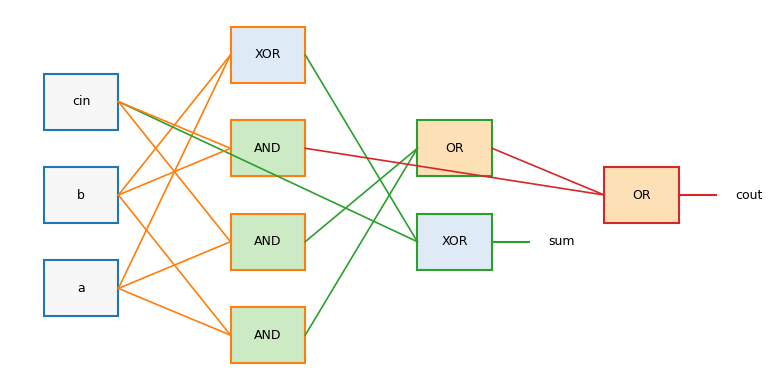

In [4]:
# ---------- Prettier logic circuit drawing with colors + gate-specific style ----------

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def compute_levels(c: Circuit) -> Dict[str, int]:
    """
    Assign each node a 'level' (x-position) based on max distance from any input.
    Primary inputs get level 0.
    """
    level: Dict[str, int] = {name: 0 for name in c.inputs}
    topo = c.topo_order()
    for name in topo:
        node = c.nodes[name]
        if node.op == "PI":
            continue
        if not node.fanins:
            level[name] = 0
        else:
            level[name] = 1 + max(level[fi] for fi in node.fanins)
    return level


def draw_logic_circuit(c: Circuit, filename: str = None, figsize=None):
    """
    Draw a classical logic circuit with:
      - colored wires/gates per level
      - slightly different styling per gate type (AND / OR / XOR / PI)
    """
    levels = compute_levels(c)
    max_level = max(levels.values()) if levels else 0

    # Group nodes by level
    level_to_nodes: Dict[int, List[str]] = {}
    for name, lvl in levels.items():
        level_to_nodes.setdefault(lvl, []).append(name)

    for lvl in level_to_nodes:
        level_to_nodes[lvl].sort()

    # Simple color palette per level
    level_colors = [
        "#1f77b4",  # blue
        "#ff7f0e",  # orange
        "#2ca02c",  # green
        "#d62728",  # red
        "#9467bd",  # purple
        "#8c564b",  # brown
        "#e377c2",  # pink
        "#7f7f7f",  # gray
        "#bcbd22",  # olive
        "#17becf",  # cyan
    ]

    def color_for_level(lvl: int) -> str:
        return level_colors[lvl % len(level_colors)]

    # Assign positions
    pos: Dict[str, Tuple[float, float]] = {}
    if figsize is None:
        figsize = (max(6, 2 * (max_level + 1)), max(4, len(c.nodes) * 0.4))

    fig, ax = plt.subplots(figsize=figsize)

    x_spacing = 2.0
    y_spacing = 1.0

    for lvl in range(max_level + 1):
        nodes_at_level = level_to_nodes.get(lvl, [])
        count = len(nodes_at_level)
        if count == 0:
            continue
        y_start = -(count - 1) * y_spacing / 2.0
        for i, name in enumerate(nodes_at_level):
            x = lvl * x_spacing
            y = y_start + i * y_spacing
            pos[name] = (x, y)

    # Draw wires (edges) first, colored by the *destination* gate's level
    for node in c.nodes.values():
        node_lvl = levels[node.name]
        wire_color = color_for_level(node_lvl)
        for fi in node.fanins:
            x0, y0 = pos[fi]
            x1, y1 = pos[node.name]
            ax.plot([x0 + 0.4, x1 - 0.4], [y0, y1],
                    linewidth=1.2, color=wire_color)

    # Draw nodes (boxes) with gate-type-specific styling
    for name, node in c.nodes.items():
        x, y = pos[name]
        w, h = 0.8, 0.6
        lvl = levels[name]
        edge_color = color_for_level(lvl)

        # Gate-type specific facecolor / label
        if node.op == "PI":
            facecolor = "#f7f7f7"
            label = name
        elif node.op == "AND":
            facecolor = "#ccebc5"  # light green
            label = "AND"
        elif node.op == "OR":
            facecolor = "#fee0b6"  # light orange
            label = "OR"
        elif node.op == "XOR":
            facecolor = "#deebf7"  # light blue
            label = "XOR"
        elif node.op == "NOT":
            facecolor = "#fddde6"  # light pink
            label = "NOT"
        else:
            facecolor = "#ffffff"
            label = node.op

        rect = Rectangle((x - w/2, y - h/2), w, h,
                         fill=True, facecolor=facecolor,
                         edgecolor=edge_color, linewidth=1.5)
        ax.add_patch(rect)
        ax.text(x, y, label, ha="center", va="center", fontsize=9)

    # Highlight outputs with a stub and label
    for out_name in c.outputs:
        x, y = pos[out_name]
        lvl = levels[out_name]
        col = color_for_level(lvl)
        ax.plot([x + 0.4, x + 0.8], [y, y], linewidth=1.5, color=col)
        ax.text(x + 1.0, y, out_name, ha="left", va="center", fontsize=9)

    ax.set_aspect("equal")
    ax.axis("off")
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# Draw the full adder circuit and save
draw_logic_circuit(full_adder, filename="full_adder_circuit.png")


In [5]:
# ---------- k-feasible cut enumeration ----------

from typing import FrozenSet

def enumerate_k_feasible_cuts(c: Circuit, k: int = None) -> Dict[str, List[Set[str]]]:
    """
    Compute k-feasible cuts for every node in the circuit.
    
    A cut for node n is a set of "leaf" nodes L such that:
        - every path from any primary input to n passes through
          at least one node in L
        - |L| <= k

    This implementation:
        - primary input pi has cuts: [{pi}]
        - for internal node:
            * combine child cuts (like standard LUT-mapping DP)
            * plus a "structural" cut of its direct fanins if <= k

    Returns:
        cuts: dict mapping node_name -> list of cuts,
              where each cut is a Python set of node names.
    """
    if k is None:
        k = c.k

    topo = c.topo_order()
    cuts: Dict[str, List[Set[str]]] = {}

    for name in topo:
        node = c.nodes[name]

        # Primary inputs: the only cut is itself
        if node.op == "PI":
            cuts[name] = [ {name} ]
            continue

        # Otherwise, combine cuts of fanins
        fanins = node.fanins
        if not fanins:
            # No fanins but not a PI? Treat as having a trivial cut of itself.
            cuts[name] = [ {name} ]
            continue

        # Start with an "empty" partial leaf set, then grow
        partials: List[Set[str]] = [ set() ]

        for fi in fanins:
            fi_cuts = cuts[fi]   # list[set]
            new_partials: List[Set[str]] = []
            for base in partials:
                for leaf_set in fi_cuts:
                    merged = base.union(leaf_set)
                    if len(merged) <= k:
                        new_partials.append(merged)
            partials = new_partials

        # Use a set of frozensets to deduplicate
        leaf_sets: Set[FrozenSet[str]] = set()
        for p in partials:
            leaf_sets.add(frozenset(p))

        # Also add the "structural" cut = direct fanins, if feasible
        struct_cut = set(fanins)
        if len(struct_cut) <= k:
            leaf_sets.add(frozenset(struct_cut))

        # Convert back to list of mutable sets
        cuts[name] = [ set(fs) for fs in leaf_sets ]

    return cuts


def print_cuts_for_circuit(c: Circuit, k: int = None):
    """
    Convenience function: compute and pretty-print k-feasible cuts for each node.
    """
    if k is None:
        k = c.k

    cuts = enumerate_k_feasible_cuts(c, k)
    print(f"k = {k} feasible cuts for circuit: {c.name}")
    for name in c.topo_order():
        print(f"\nNode {name} (op={c.nodes[name].op}):")
        node_cuts = cuts[name]
        for i, leaf_set in enumerate(node_cuts):
            leaves_str = ", ".join(sorted(leaf_set))
            print(f"  Cut {i}: {{{leaves_str}}}")


# Example: enumerate cuts for the 1-bit full adder
print_cuts_for_circuit(full_adder, k=4)



k = 4 feasible cuts for circuit: full_adder

Node a (op=PI):
  Cut 0: {a}

Node b (op=PI):
  Cut 0: {b}

Node cin (op=PI):
  Cut 0: {cin}

Node s1 (op=XOR):
  Cut 0: {a, b}

Node c1 (op=AND):
  Cut 0: {a, b}

Node c2 (op=AND):
  Cut 0: {a, cin}

Node c3 (op=AND):
  Cut 0: {b, cin}

Node sum (op=XOR):
  Cut 0: {cin, s1}
  Cut 1: {a, b, cin}

Node t1 (op=OR):
  Cut 0: {c1, c2}
  Cut 1: {a, b, cin}

Node cout (op=OR):
  Cut 0: {b, c1, c2, cin}
  Cut 1: {c3, t1}
  Cut 2: {a, b, cin}


In [6]:
# ---------- Cut visualization: highlight leaf sets for a chosen node ----------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_logic_circuit(c: Circuit, highlight_nodes: Set[str] = None,
                       filename: str = None, figsize=None):
    """
    Draw the classical logic circuit with:
      - colored wires/gates per level
      - gate-type-specific fill colors
      - optional 'highlight_nodes' set (nodes drawn with thicker border)
    """
    if highlight_nodes is None:
        highlight_nodes = set()

    levels = compute_levels(c)
    max_level = max(levels.values()) if levels else 0

    # Group nodes by level
    level_to_nodes: Dict[int, List[str]] = {}
    for name, lvl in levels.items():
        level_to_nodes.setdefault(lvl, []).append(name)

    for lvl in level_to_nodes:
        level_to_nodes[lvl].sort()

    # Simple color palette per level
    level_colors = [
        "#1f77b4",  # blue
        "#ff7f0e",  # orange
        "#2ca02c",  # green
        "#d62728",  # red
        "#9467bd",  # purple
        "#8c564b",  # brown
        "#e377c2",  # pink
        "#7f7f7f",  # gray
        "#bcbd22",  # olive
        "#17becf",  # cyan
    ]

    def color_for_level(lvl: int) -> str:
        return level_colors[lvl % len(level_colors)]

    # Assign positions
    pos: Dict[str, Tuple[float, float]] = {}
    if figsize is None:
        figsize = (max(6, 2 * (max_level + 1)), max(4, len(c.nodes) * 0.4))

    fig, ax = plt.subplots(figsize=figsize)

    x_spacing = 2.0
    y_spacing = 1.0

    for lvl in range(max_level + 1):
        nodes_at_level = level_to_nodes.get(lvl, [])
        count = len(nodes_at_level)
        if count == 0:
            continue
        y_start = -(count - 1) * y_spacing / 2.0
        for i, name in enumerate(nodes_at_level):
            x = lvl * x_spacing
            y = y_start + i * y_spacing
            pos[name] = (x, y)

    # Draw wires (edges)
    for node in c.nodes.values():
        node_lvl = levels[node.name]
        wire_color = color_for_level(node_lvl)
        for fi in node.fanins:
            x0, y0 = pos[fi]
            x1, y1 = pos[node.name]
            ax.plot([x0 + 0.4, x1 - 0.4], [y0, y1],
                    linewidth=1.2, color=wire_color)

    # Draw nodes (boxes)
    for name, node in c.nodes.items():
        x, y = pos[name]
        w, h = 0.8, 0.6
        lvl = levels[name]
        edge_color = color_for_level(lvl)

        # Gate-type specific fill
        if node.op == "PI":
            facecolor = "#f7f7f7"
            label = name
        elif node.op == "AND":
            facecolor = "#ccebc5"  # light green
            label = "AND"
        elif node.op == "OR":
            facecolor = "#fee0b6"  # light orange
            label = "OR"
        elif node.op == "XOR":
            facecolor = "#deebf7"  # light blue
            label = "XOR"
        elif node.op == "NOT":
            facecolor = "#fddde6"  # light pink
            label = "NOT"
        else:
            facecolor = "#ffffff"
            label = node.op

        # Thicker border if highlighted
        lw = 2.5 if name in highlight_nodes else 1.5

        rect = Rectangle((x - w/2, y - h/2), w, h,
                         fill=True, facecolor=facecolor,
                         edgecolor=edge_color, linewidth=lw)
        ax.add_patch(rect)
        ax.text(x, y, label, ha="center", va="center", fontsize=9)

    # Outputs
    for out_name in c.outputs:
        x, y = pos[out_name]
        lvl = levels[out_name]
        col = color_for_level(lvl)
        ax.plot([x + 0.4, x + 0.8], [y, y], linewidth=1.5, color=col)
        ax.text(x + 1.0, y, out_name, ha="left", va="center", fontsize=9)

    ax.set_aspect("equal")
    ax.axis("off")
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

def visualize_cuts_for_node(c: Circuit, node_name: str, k: int = None):
    """
    For a given node, compute its k-feasible cuts and:
      - print each cut's leaf set
      - draw the circuit highlighting that node + its leaf nodes
    Assumes draw_logic_circuit(c, highlight_nodes=...) exists.
    """
    if k is None:
        k = c.k

    all_cuts = enumerate_k_feasible_cuts(c, k)
    node_cuts = all_cuts[node_name]

    print(f"k = {k} cuts for node {node_name}:")
    for i, leaf_set in enumerate(node_cuts):
        leaves_str = ", ".join(sorted(leaf_set))
        print(f"\nCut {i}: {{{leaves_str}}}")

        # Highlight root + leaves
        highlight = set(leaf_set) | {node_name}
        filename = f"{c.name}_{node_name}_cut{i}.png"
        draw_logic_circuit(c, highlight_nodes=highlight, filename=filename)
        print(f"  -> saved visualization as {filename}")


# Example: visualize cuts for 'sum' and 'cout'
# visualize_cuts_for_node(full_adder, "sum", k=4)
# visualize_cuts_for_node(full_adder, "cout", k=4)


In [7]:

# ---------- QUBO: cut variables + exactly-one constraints ----------

from typing import FrozenSet, Optional

def build_cut_variable_index(c: Circuit, k: int = None):
    """
    Enumerate k-feasible cuts, then assign a binary variable x_{n,c} for each:
        non-PI node n and each of its cuts.
    """
    if k is None:
        k = c.k

    cuts = enumerate_k_feasible_cuts(c, k)

    var_index: Dict[Tuple[str, int], int] = {}
    index_to_var: List[Tuple[str, int]] = []

    next_idx = 0
    for name in c.topo_order():
        node = c.nodes[name]
        if node.op == "PI":
            continue

        node_cuts = cuts[name]
        for ci, _leaf_set in enumerate(node_cuts):
            var_index[(name, ci)] = next_idx
            index_to_var.append((name, ci))
            next_idx += 1

    print(f"Total QUBO variables (cut choices): {next_idx}")
    return cuts, var_index, index_to_var


def add_exactly_one_constraint(Q: np.ndarray,
                               node_name: str,
                               cuts_for_node: List[Set[str]],
                               var_index: Dict[Tuple[str, int], int],
                               penalty: float,
                               constant_offset: float) -> float:
    """
    Add penalty λ(sum_c x_{n,c} - 1)^2 for this node, by modifying Q (in-place)
    and returning the updated constant offset.
    """
    idxs = [var_index[(node_name, ci)] for ci in range(len(cuts_for_node))]

    # Diagonal: each x_i gets coefficient -λ
    for i in idxs:
        Q[i, i] += -penalty

    # Off-diagonal: each x_i x_j pair gets coefficient +2λ, so Q_ij = λ
    for a in range(len(idxs)):
        for b in range(a + 1, len(idxs)):
            i = idxs[a]
            j = idxs[b]
            Q[i, j] += penalty
            Q[j, i] += penalty  # keep symmetric

    # Constant term +λ
    constant_offset += penalty
    return constant_offset


def build_qubo_exact_one_only(c: Circuit, k: int = None, penalty: float = 1.0):
    """
    Build Q and constant_offset encoding ONLY 'exactly one cut per node'
    for all non-PI nodes.
    """
    cuts, var_index, index_to_var = build_cut_variable_index(c, k)
    n_vars = len(index_to_var)
    Q = np.zeros((n_vars, n_vars), dtype=float)
    constant_offset = 0.0

    for name in c.topo_order():
        if c.nodes[name].op == "PI":
            continue
        node_cuts = cuts[name]
        constant_offset = add_exactly_one_constraint(
            Q, name, node_cuts, var_index,
            penalty=penalty,
            constant_offset=constant_offset
        )

    return Q, cuts, var_index, index_to_var, constant_offset


# Example: QUBO for full adder
Q_exact, cuts_fa, var_index_fa, index_to_var_fa, const_offset_fa = build_qubo_exact_one_only(
    full_adder, k=4, penalty=1.0
)
print("QUBO shape:", Q_exact.shape)
print("Constant offset:", const_offset_fa)
# print("First few variables (node, cut_idx):", index_to_var_fa[:10])
print(Q_exact)



Total QUBO variables (cut choices): 11
QUBO shape: (11, 11)
Constant offset: 7.0
[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1. -1.]]


In [8]:

# ---------- Brute-force check: is 'exactly one cut per node' enforced? ----------

from itertools import product

def qubo_energy(x, Q, const_offset=0.0):
    x = np.asarray(x, dtype=float)
    return float(x @ Q @ x + const_offset)


def check_exactly_one_per_node(x,
                               c: Circuit,
                               cuts: Dict[str, List[Set[str]]],
                               var_index: Dict[Tuple[str, int], int]) -> bool:
    x = np.asarray(x, dtype=int)
    for name in c.topo_order():
        if c.nodes[name].op == "PI":
            continue
        node_cuts = cuts[name]
        idxs = [var_index[(name, ci)] for ci in range(len(node_cuts))]
        s = x[idxs].sum()
        if s != 1:
            return False
    return True


def brute_force_check_exact_one(Q, const_offset,
                                c: Circuit,
                                cuts: Dict[str, List[Set[str]]],
                                var_index: Dict[Tuple[str, int], int],
                                index_to_var: List[Tuple[str, int]]):
    n_vars = Q.shape[0]
    print(f"Brute-force over {n_vars} variables (2^{n_vars} assignments)...")

    min_E = None
    minimizers = []

    for bits in product([0, 1], repeat=n_vars):
        x = np.array(bits, dtype=int)
        E = qubo_energy(x, Q, const_offset)
        if (min_E is None) or (E < min_E - 1e-9):
            min_E = E
            minimizers = [x]
        elif abs(E - min_E) < 1e-9:
            minimizers.append(x)

    print(f"\nMinimum energy: {min_E}")
    print(f"Number of minimizers: {len(minimizers)}")

    all_ok = True
    for idx, x in enumerate(minimizers):
        if not check_exactly_one_per_node(x, c, cuts, var_index):
            all_ok = False
            print(f"  Minimizer {idx} violates exactly-one: x = {x}")

    if all_ok:
        print("✅ All minimum-energy assignments satisfy exactly-one-cut-per-node.")
    else:
        print("❌ Some minimum-energy assignments violate the constraint.")

    print("\nExample minimizer decoded as (node, cut_idx):")
    x0 = minimizers[0]
    for i, bit in enumerate(x0):
        if bit == 1:
            node_name, cut_idx = index_to_var[i]
            print(f"  {node_name}, cut {cut_idx} selected")

    return min_E, minimizers


In [9]:
# ---------- Model A: Constraints only (exactly one cut per node) ----------

def build_model_A_qubo(c: Circuit, k: int = None, penalty_exact: float = 1.0):
    """
    Model A:
      - Variables: one x_{n,c} per (node, cut)
      - Constraints: for each non-PI node n, sum_c x_{n,c} = 1
      - Objective: just satisfy constraints (no extra cost)
    """
    Q_exact, cuts, var_index, index_to_var, const_offset = build_qubo_exact_one_only(
        c, k=k, penalty=penalty_exact
    )
    return Q_exact, cuts, var_index, index_to_var, const_offset


In [11]:
Q_A, cuts_A, var_index_A, index_to_var_A, const_A = build_model_A_qubo(full_adder, k=4)
print("QUBO shape:", Q_A.shape)
print("Constant offset:", const_A)
# print("First few variables (node, cut_idx):", index_to_var_fa[:10])
print(Q_exact,"\n")

# -------- BRUTE FORCE VERIFICATION ----------------
min_E_A, minimizers_A = brute_force_check_exact_one(
    Q_A, const_A,
    full_adder, cuts_A, var_index_A, index_to_var_A
)

Total QUBO variables (cut choices): 11
QUBO shape: (11, 11)
Constant offset: 7.0
[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1. -1.]] 

Brute-force over 11 variables (2^11 assignments)...

Minimum energy: 0.0
Number of minimizers: 12
✅ All minimum-energy assignments satisfy exactly-one-cut-per-node.

Example minimizer decoded as (node, cut_idx):
  s1, cut 0 selected
  c1, cut 0 selected
  c2, cut 0 selected
  c3, cut 0 selected
  sum, cut 1 selected
  t1, cut 1 selected
  cout, cut 2 selected


In [12]:
# ---------- Linear PI-bias cost: penalize internal leaves in each cut ----------

def add_pi_bias_cost(Q: np.ndarray,
                     c: Circuit,
                     cuts: Dict[str, List[Set[str]]],
                     var_index: Dict[Tuple[str, int], int],
                     alpha_pi: float = 0.1) -> np.ndarray:
    """
    PI-bias objective:
        E_pi = alpha_pi * sum_{n,c} (# of non-PI leaves in cut (n,c)) * x_{n,c}

    This prefers cuts whose leaves are closer to primary inputs.
    Implemented as diagonal additions to Q.
    """
    Q_pi = Q.copy()

    # Identify primary-input node names
    pi_names = {name for name, node in c.nodes.items() if node.op == "PI"}

    for (node_name, cut_idx), var_id in var_index.items():
        leaf_set = cuts[node_name][cut_idx]
        internal_count = sum(1 for leaf in leaf_set if leaf not in pi_names)
        if internal_count > 0:
            Q_pi[var_id, var_id] += alpha_pi * internal_count

    return Q_pi

# ---------- Model B: Constraints + PI-bias ----------

def build_model_B_qubo(c: Circuit,
                       k: int = None,
                       penalty_exact: float = 1.0,
                       alpha_pi: float = 0.1):
    """
    Model B:
      - Same variables and exactly-one constraints as Model A
      - Additional linear objective term:
            E_pi = alpha_pi * (# internal leaves per cut) * x_{n,c}
    """
    Q_exact, cuts, var_index, index_to_var, const_offset = build_qubo_exact_one_only(
        c, k=k, penalty=penalty_exact
    )
    Q_B = add_pi_bias_cost(Q_exact, c, cuts, var_index, alpha_pi=alpha_pi)
    return Q_B, cuts, var_index, index_to_var, const_offset


In [13]:
Q_B, cuts_B, var_index_B, index_to_var_B, const_B = build_model_B_qubo(full_adder, k=4,
                                                                       penalty_exact=1.0,
                                                                       alpha_pi=0.1)
print(f"QUBO with input node bias penalty\n{Q_B}\n")

min_E_B, minimizers_B = brute_force_check_exact_one(
    Q_B, const_B,
    full_adder, cuts_B, var_index_B, index_to_var_B
)
# print(minimizers)

Total QUBO variables (cut choices): 11
QUBO with input node bias penalty
[[-1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.9  1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.  -1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.8  1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.  -1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.8  1.   1. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1.  -0.8  1. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1.   1.  -1. ]]

Brute-force over 11 variables (2^11 assignments)...

Minimum energy: 0.0
Number of minimizers: 1
✅ All minimum-energy assignments satisfy exactly-one-cut-per-node.

Example minimizer decoded as (node, cut_idx):
  s1, cut 0 selected
  c1, cut 0 selected
  c2, cut 0 selected
  c3, cut 0 s

In [14]:
# ---------- Quadratic fanout-duplication penalty ----------

def add_fanout_duplication_cost(Q: np.ndarray,
                                c: Circuit,
                                cuts: Dict[str, List[Set[str]]],
                                var_index: Dict[Tuple[str, int], int],
                                index_to_var: List[Tuple[str, int]],
                                lam_dup: float = 0.2) -> np.ndarray:
    """
    Quadratic fanout-duplication objective:
        E_dup = lam_dup * sum_{(u,c),(v,d)} |internal_leaves(u,c) ∩ internal_leaves(v,d)| * x_{u,c} x_{v,d}

    Only pairs (u,c),(v,d) with u != v and non-empty intersection contribute.
    Implemented as off-diagonal additions to Q.
    """
    Q_dup = Q.copy()

    # Precompute PI set and internal-leaf sets for each variable
    pi_names = {name for name, node in c.nodes.items() if node.op == "PI"}

    internal_leaves_by_varid: Dict[int, Set[str]] = {}
    for var_id, (node_name, cut_idx) in enumerate(index_to_var):
        leaf_set = cuts[node_name][cut_idx]
        internal = {leaf for leaf in leaf_set if leaf not in pi_names}
        internal_leaves_by_varid[var_id] = internal

    n_vars = len(index_to_var)

    for i in range(n_vars):
        node_i, cut_i = index_to_var[i]
        internal_i = internal_leaves_by_varid[i]
        if not internal_i:
            continue  # no internal leaves, no duplication impact

        for j in range(i + 1, n_vars):
            node_j, cut_j = index_to_var[j]
            if node_i == node_j:
                continue  # we don't penalize within a single node; that's handled by exact-one

            internal_j = internal_leaves_by_varid[j]
            if not internal_j:
                continue

            shared = internal_i & internal_j
            if not shared:
                continue

            # weight is proportional to how many internal leaves are shared
            w_ij = lam_dup * len(shared)

            # For QUBO, coefficient in E(x) is w_ij * x_i x_j,
            # so we add w_ij / 2 to Q[i,j] and Q[j,i].
            Q_dup[i, j] += 0.5 * w_ij
            Q_dup[j, i] += 0.5 * w_ij

    return Q_dup

# ---------- Model C: Constraints + fanout-duplication ----------

def build_model_C_qubo(c: Circuit,
                       k: int = None,
                       penalty_exact: float = 1.0,
                       lam_dup: float = 0.2):
    """
    Model C:
      - Same variables and exactly-one constraints as Model A
      - Additional quadratic objective term for fanout duplication:
            E_dup = lam_dup * Σ shared_internal_leaves * x_{u,c} x_{v,d}
    """
    Q_exact, cuts, var_index, index_to_var, const_offset = build_qubo_exact_one_only(
        c, k=k, penalty=penalty_exact
    )
    Q_C = add_fanout_duplication_cost(Q_exact, c, cuts, var_index,
                                      index_to_var, lam_dup=lam_dup)
    return Q_C, cuts, var_index, index_to_var, const_offset


In [15]:
Q_C, cuts_C, var_index_C, index_to_var_C, const_C = build_model_C_qubo(full_adder, k=4,
                                                                       penalty_exact=1.0,
                                                                       lam_dup=0.2)
print(f"QUBO with duplication penalty\n{Q_C}\n")

min_E_C, minimizers_C = brute_force_check_exact_one(
    Q_C, const_C,
    full_adder, cuts_C, var_index_C, index_to_var_C
)
# for m in minimizers:
#     print(m)

Total QUBO variables (cut choices): 11
QUBO with duplication penalty
[[-1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.  -1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   1.   0.2  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.  -1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.2  0.  -1.   1.   1. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1.  -1.   1. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1.   1.  -1. ]]

Brute-force over 11 variables (2^11 assignments)...

Minimum energy: 0.0
Number of minimizers: 10
✅ All minimum-energy assignments satisfy exactly-one-cut-per-node.

Example minimizer decoded as (node, cut_idx):
  s1, cut 0 selected
  c1, cut 0 selected
  c2, cut 0 selected
  c3, cut 0 sele

In [16]:
def decode_solution(x, index_to_var, cuts):
    """
    Given a 0/1 vector x and (index_to_var, cuts), return a list of
    (node_name, cut_idx, sorted_leaves) for variables set to 1.
    """
    chosen = []
    for i, bit in enumerate(x):
        if bit == 1:
            node_name, cut_idx = index_to_var[i]
            leaves = sorted(cuts[node_name][cut_idx])
            chosen.append((node_name, cut_idx, leaves))
    return chosen

def compute_cut_metrics(c: Circuit, cuts):
    """
    Return dict:
        metrics[node_name][cut_idx] = {
            "leaves": [...],
            "num_leaves": int,
            "num_internal_leaves": int,
        }
    """
    pi_names = {name for name, node in c.nodes.items() if node.op == "PI"}
    metrics = {}

    for node_name, cut_list in cuts.items():
        metrics[node_name] = {}
        for ci, leaf_set in enumerate(cut_list):
            leaves_sorted = sorted(leaf_set)
            num_leaves = len(leaf_set)
            num_internal = sum(1 for leaf in leaf_set if leaf not in pi_names)
            metrics[node_name][ci] = {
                "leaves": leaves_sorted,
                "num_leaves": num_leaves,
                "num_internal_leaves": num_internal,
            }

    return metrics

def chosen_cut_map(chosen_list):
    """
    From list of (node_name, cut_idx, leaves), return dict[node_name] = cut_idx
    """
    m = {}
    for node_name, cut_idx, _ in chosen_list:
        m[node_name] = cut_idx
    return m



In [17]:
xA = minimizers_A[0] # pick first minimizer as representative
xB = minimizers_B[0]
xC = minimizers_C[0]

chosen_A = decode_solution(xA, index_to_var_A, cuts_A)
chosen_B = decode_solution(xB, index_to_var_B, cuts_B)
chosen_C = decode_solution(xC, index_to_var_C, cuts_C)

chosen_A_map = chosen_cut_map(chosen_A)
chosen_B_map = chosen_cut_map(chosen_B)
chosen_C_map = chosen_cut_map(chosen_C)

In [18]:
metrics_A = compute_cut_metrics(full_adder, cuts_A)  # cuts_A == cuts_B == cuts_C if built similarly

print("=== Per-node cut options and model choices ===\n")

for node_name in full_adder.topo_order():
    if full_adder.nodes[node_name].op == "PI":
        continue  # skip primary inputs

    print(f"Node: {node_name}")

    for ci, m in metrics_A[node_name].items():
        chosen_by = []
        if chosen_A_map.get(node_name, None) == ci:
            chosen_by.append("A")
        if chosen_B_map.get(node_name, None) == ci:
            chosen_by.append("B")
        if chosen_C_map.get(node_name, None) == ci:
            chosen_by.append("C")

        print(f"  Cut {ci}:")
        print(f"    Leaves: {m['leaves']}")
        print(f"    #leaves: {m['num_leaves']}")
        print(f"    #internal_leaves: {m['num_internal_leaves']}")
        print(f"    Chosen by models: {chosen_by if chosen_by else 'none'}")

    print()  # blank line between nodes


=== Per-node cut options and model choices ===

Node: s1
  Cut 0:
    Leaves: ['a', 'b']
    #leaves: 2
    #internal_leaves: 0
    Chosen by models: ['A', 'B', 'C']

Node: c1
  Cut 0:
    Leaves: ['a', 'b']
    #leaves: 2
    #internal_leaves: 0
    Chosen by models: ['A', 'B', 'C']

Node: c2
  Cut 0:
    Leaves: ['a', 'cin']
    #leaves: 2
    #internal_leaves: 0
    Chosen by models: ['A', 'B', 'C']

Node: c3
  Cut 0:
    Leaves: ['b', 'cin']
    #leaves: 2
    #internal_leaves: 0
    Chosen by models: ['A', 'B', 'C']

Node: sum
  Cut 0:
    Leaves: ['cin', 's1']
    #leaves: 2
    #internal_leaves: 1
    Chosen by models: none
  Cut 1:
    Leaves: ['a', 'b', 'cin']
    #leaves: 3
    #internal_leaves: 0
    Chosen by models: ['A', 'B', 'C']

Node: t1
  Cut 0:
    Leaves: ['c1', 'c2']
    #leaves: 2
    #internal_leaves: 2
    Chosen by models: none
  Cut 1:
    Leaves: ['a', 'b', 'cin']
    #leaves: 3
    #internal_leaves: 0
    Chosen by models: ['A', 'B', 'C']

Node: cout
  Cut 0

In [19]:
def plot_pi_bias_for_node(node_name, metrics, chosen_B_map):
    cut_idxs = sorted(metrics[node_name].keys())
    vals = [metrics[node_name][ci]["num_internal_leaves"] for ci in cut_idxs]

    plt.figure()
    plt.bar(cut_idxs, vals)
    plt.xlabel("Cut index")
    plt.ylabel("# internal leaves")
    plt.title(f"PI-bias metric for node {node_name}")

    chosen_ci = chosen_B_map.get(node_name, None)
    if chosen_ci is not None:
        # annotate chosen cut
        plt.text(chosen_ci, vals[cut_idxs.index(chosen_ci)] + 0.1,
                 "Model B choice", ha="center")

    plt.show()

In [20]:
# for node_name in full_adder.topo_order():
#     if full_adder.nodes[node_name].op == "PI":
#         continue
#     plot_pi_bias_for_node(node_name, metrics_A, chosen_B_map)

In [21]:
def duplication_score_for_node_and_cut(node_name, cut_idx,
                                       c, cuts, chosen_map, index_to_var):
    pi_names = {name for name, node in c.nodes.items() if node.op == "PI"}
    target_leaves = {leaf for leaf in cuts[node_name][cut_idx] if leaf not in pi_names}

    score = 0
    for other_node, other_cut_idx in chosen_map.items():
        if other_node == node_name:
            continue
        other_leaves = {leaf for leaf in cuts[other_node][other_cut_idx] if leaf not in pi_names}
        score += len(target_leaves & other_leaves)
    return score


In [22]:
from collections import defaultdict

def compute_selection_frequencies(minimizers, index_to_var, cuts, circuit):
    """
    For a set of minimizers, compute how often each (node, cut_idx) is chosen.

    Returns:
      freq[node_name][cut_idx] = fraction in [0,1]
    """
    counts = defaultdict(lambda: defaultdict(int))
    total = len(minimizers)

    # For each minimizer, find which cuts are chosen
    for x in minimizers:
        x = np.asarray(x, dtype=int)
        for var_id, bit in enumerate(x):
            if bit == 1:
                node_name, cut_idx = index_to_var[var_id]
                counts[node_name][cut_idx] += 1

    # Convert to frequencies
    freqs = {}
    for node_name, cut_dict in counts.items():
        freqs[node_name] = {}
        for cut_idx, count in cut_dict.items():
            freqs[node_name][cut_idx] = count / total

    return freqs


In [23]:
freqs_A = compute_selection_frequencies(minimizers_A, index_to_var_A, cuts_A, full_adder)
freqs_B = compute_selection_frequencies(minimizers_B, index_to_var_B, cuts_B, full_adder)
freqs_C = compute_selection_frequencies(minimizers_C, index_to_var_C, cuts_C, full_adder)

In [24]:
def nodes_with_multiple_cuts(cuts):
    return [node_name for node_name, cut_list in cuts.items()
            if len(cut_list) > 1]
multi_cut_nodes = nodes_with_multiple_cuts(cuts_A)
metrics = compute_cut_metrics(full_adder, cuts_A)

In [25]:
print("=== Model A/B/C behavior on nodes with multiple cuts ===\n")

for node_name in multi_cut_nodes:
    print(f"Node: {node_name}")
    for ci, m in metrics[node_name].items():
        leaves = m["leaves"]
        num_leaves = m["num_leaves"]
        num_internal = m["num_internal_leaves"]

        fA = freqs_A.get(node_name, {}).get(ci, 0.0)
        fB = freqs_B.get(node_name, {}).get(ci, 0.0)
        fC = freqs_C.get(node_name, {}).get(ci, 0.0)

        print(f"  Cut {ci}:")
        print(f"    Leaves: {leaves}")
        print(f"    #leaves: {num_leaves}")
        print(f"    #internal_leaves: {num_internal}")
        print(f"    Selection frequency:")
        print(f"      Model A: {fA:.2f}")
        print(f"      Model B (PI-bias): {fB:.2f}")
        print(f"      Model C (fanout-dup): {fC:.2f}")
    print()


=== Model A/B/C behavior on nodes with multiple cuts ===

Node: sum
  Cut 0:
    Leaves: ['cin', 's1']
    #leaves: 2
    #internal_leaves: 1
    Selection frequency:
      Model A: 0.50
      Model B (PI-bias): 0.00
      Model C (fanout-dup): 0.50
  Cut 1:
    Leaves: ['a', 'b', 'cin']
    #leaves: 3
    #internal_leaves: 0
    Selection frequency:
      Model A: 0.50
      Model B (PI-bias): 1.00
      Model C (fanout-dup): 0.50

Node: t1
  Cut 0:
    Leaves: ['c1', 'c2']
    #leaves: 2
    #internal_leaves: 2
    Selection frequency:
      Model A: 0.50
      Model B (PI-bias): 0.00
      Model C (fanout-dup): 0.40
  Cut 1:
    Leaves: ['a', 'b', 'cin']
    #leaves: 3
    #internal_leaves: 0
    Selection frequency:
      Model A: 0.50
      Model B (PI-bias): 1.00
      Model C (fanout-dup): 0.60

Node: cout
  Cut 0:
    Leaves: ['b', 'c1', 'c2', 'cin']
    #leaves: 4
    #internal_leaves: 2
    Selection frequency:
      Model A: 0.33
      Model B (PI-bias): 0.00
      Model C (

In [26]:
def expected_internal_leaves_per_model(metrics, freqs):
    """
    metrics[node][ci]['num_internal_leaves']
    freqs[node][ci] = selection frequency
    Returns:
      per_node[node] = expected internal leaves at that node
      global_total = sum over nodes
    """
    per_node = {}
    global_total = 0.0
    for node_name, cuts_metrics in metrics.items():
        # skip nodes with only one cut if you want
        if len(cuts_metrics) <= 1:
            continue

        e_int = 0.0
        for ci, m in cuts_metrics.items():
            internal = m["num_internal_leaves"]
            f = freqs.get(node_name, {}).get(ci, 0.0)
            e_int += f * internal
        per_node[node_name] = e_int
        global_total += e_int

    return per_node, global_total

per_node_B, global_B = expected_internal_leaves_per_model(metrics, freqs_B)
per_node_C, global_C = expected_internal_leaves_per_model(metrics, freqs_C)

print(f"Expected # of internal leaves per node for model B: {per_node_B}")
print(f"Expected total # of internal leaves for model B: {global_B}")
print(f"Expected # of internal leaves per node for model C: {per_node_C}")
print(f"Expected total # of internal leaves for model C: {global_C}")


Expected # of internal leaves per node for model B: {'sum': 0.0, 't1': 0.0, 'cout': 0.0}
Expected total # of internal leaves for model B: 0.0
Expected # of internal leaves per node for model C: {'sum': 0.5, 't1': 0.8, 'cout': 1.2000000000000002}
Expected total # of internal leaves for model C: 2.5


In [27]:
def plot_selection_frequencies_for_node(node_name,
                                        cuts,
                                        freqs_A, freqs_B, freqs_C):
    cut_idxs = list(range(len(cuts[node_name])))

    vals_A = [freqs_A.get(node_name, {}).get(ci, 0.0) for ci in cut_idxs]
    vals_B = [freqs_B.get(node_name, {}).get(ci, 0.0) for ci in cut_idxs]
    vals_C = [freqs_C.get(node_name, {}).get(ci, 0.0) for ci in cut_idxs]

    x = np.arange(len(cut_idxs))  # positions
    width = 0.25

    plt.figure()
    plt.bar(x - width, vals_A, width, label="Model A")
    plt.bar(x,         vals_B, width, label="Model B (PI-bias)")
    plt.bar(x + width, vals_C, width, label="Model C (fanout-dup)")

    plt.xticks(x, [f"cut {ci}" for ci in cut_idxs])
    plt.ylim(0, 1.05)
    plt.ylabel("Selection frequency")
    plt.title(f"Cut selection frequencies for node {node_name}")
    plt.legend()
    plt.show()

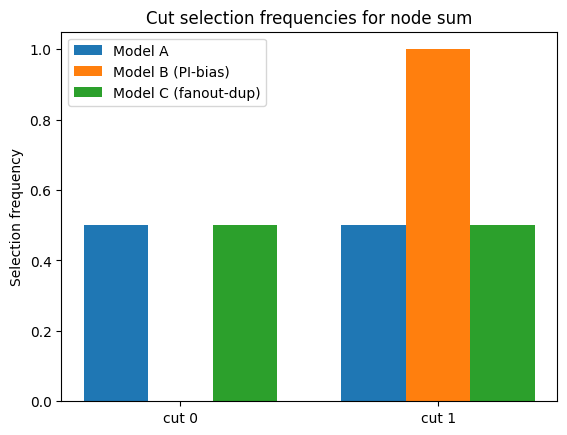

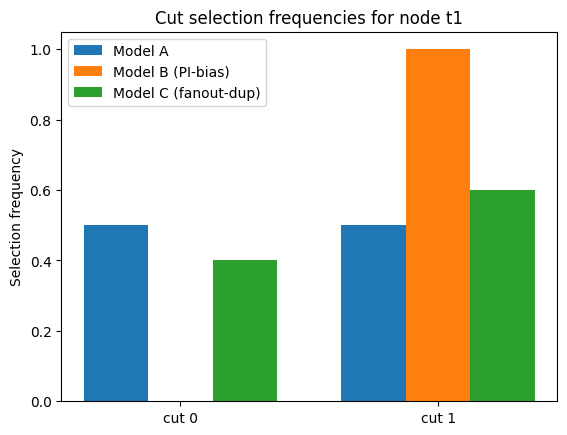

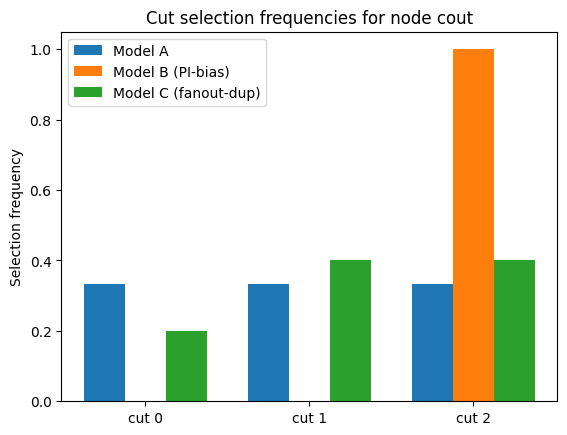

In [28]:
for node_name in multi_cut_nodes:
    plot_selection_frequencies_for_node(node_name,
                                        cuts_A,
                                        freqs_A, freqs_B, freqs_C)


QAOA BELOW

In [29]:
import numpy as np
from scipy.optimize import minimize

# ---- QUBO -> energies for all bitstrings ----

def qubo_energy_all_bitstrings(Q: np.ndarray, const_offset: float = 0.0):
    """
    Precompute E(x) = x^T Q x + const_offset for all bitstrings x in {0,1}^n.
    Bit order: x[i] is qubit i (LSB), index k encodes bits in binary.
    Returns an array E_all of length 2^n with E_all[k] = E(x_k).
    """
    n = Q.shape[0]
    assert Q.shape == (n, n)
    Qs = 0.5 * (Q + Q.T)

    num_states = 1 << n
    energies = np.zeros(num_states, dtype=float)

    for k in range(num_states):
        x = np.array([(k >> i) & 1 for i in range(n)], dtype=float)
        energies[k] = x @ Qs @ x + const_offset

    return energies

# Example: precompute for your Model B
E_all_B = qubo_energy_all_bitstrings(Q_B, const_offset=const_B)
n_B = Q_B.shape[0]
print("Model B: n =", n_B, "num_states =", 1 << n_B)
print("Classical minimum energy:", E_all_B.min())

Model B: n = 11 num_states = 2048
Classical minimum energy: 0.0


In [30]:
# ---- basic QAOA building blocks ----

def initial_uniform_state(n_qubits: int):
    """
    |s> = (1/sqrt(2^n)) sum_x |x>
    """
    num_states = 1 << n_qubits
    return np.ones(num_states, dtype=complex) / np.sqrt(num_states)


def apply_cost_layer(psi: np.ndarray, E_all: np.ndarray, gamma: float):
    """
    Cost layer U_C(gamma): |x> -> exp(-i * gamma * E(x)) |x>
    """
    phases = np.exp(-1j * gamma * E_all)
    return psi * phases


def apply_mixer_layer(psi: np.ndarray, beta: float, n_qubits: int):
    """
    Mixer layer U_B(beta) = exp(-i beta sum_i X_i),
    implemented as exp(-i beta X) on each qubit, acting on the statevector.
    """
    cosb = np.cos(beta)
    sinb = np.sin(beta)
    state = psi.copy()

    for q in range(n_qubits):
        step = 1 << q  # 2^q
        new_state = state.copy()

        for base in range(0, len(state), 2 * step):
            for off in range(step):
                i0 = base + off        # bit q = 0
                i1 = i0 + step         # bit q = 1

                a0 = state[i0]
                a1 = state[i1]

                # [a0']   [ cosβ      -i sinβ ] [a0]
                # [a1'] = [ -i sinβ    cosβ   ] [a1]
                new_state[i0] = cosb * a0 - 1j * sinb * a1
                new_state[i1] = -1j * sinb * a0 + cosb * a1

        state = new_state

    return state

In [31]:
# ---- general p-layer QAOA ----

def qaoa_state_p(gammas, betas, E_all):
    """
    QAOA state for depth p = len(gammas) = len(betas):
      |psi> = U_B(beta_p) U_C(gamma_p) ... U_B(beta_1) U_C(gamma_1) |s>
    """
    gammas = np.asarray(gammas, dtype=float)
    betas  = np.asarray(betas, dtype=float)
    assert gammas.shape == betas.shape
    p = len(gammas)

    n = int(np.log2(len(E_all)))
    psi = initial_uniform_state(n)

    for k in range(p):
        psi = apply_cost_layer(psi, E_all, gammas[k])
        psi = apply_mixer_layer(psi, betas[k], n)

    return psi


def qaoa_energy_p(theta, E_all, p):
    """
    theta: length 2p vector [gamma_1,...,gamma_p, beta_1,...,beta_p]
    returns <psi(theta)| H_cost |psi(theta)>
    """
    theta = np.asarray(theta, dtype=float)
    assert theta.shape[0] == 2 * p

    gammas = theta[:p]
    betas  = theta[p:]

    psi = qaoa_state_p(gammas, betas, E_all)
    probs = np.abs(psi)**2
    return float(np.sum(probs * E_all))


def run_qaoa_optimization(E_all, p=1, theta0=None, maxiter=80, method="Nelder-Mead"):
    """
    Run classical optimization over (gammas, betas) for depth p.
    Returns (result, gammas_opt, betas_opt, psi_opt, probs_opt).
    """
    if theta0 is None:
        # default initial guess: all gammas=1.0, all betas=1.0
        theta0 = np.ones(2 * p, dtype=float)

    def energy_vec(theta):
        return qaoa_energy_p(theta, E_all, p)

    res = minimize(
        energy_vec,
        x0=np.asarray(theta0, dtype=float),
        method=method,
        options={"maxiter": maxiter, "disp": True},
    )

    opt_theta = res.x
    gammas_opt = opt_theta[:p]
    betas_opt  = opt_theta[p:]

    psi_opt = qaoa_state_p(gammas_opt, betas_opt, E_all)
    probs_opt = np.abs(psi_opt)**2

    return res, gammas_opt, betas_opt, psi_opt, probs_opt


# ---- utilities to inspect bitstrings ----

def idx_to_bits(idx, n):
    return format(idx, f"0{n}b")


def show_top_by_probability(probs, E_all, n, k=10, title="Top by probability"):
    idxs = np.argsort(-probs)  # descending prob
    print(title)
    for idx in idxs[:k]:
        print(idx_to_bits(idx, n), "prob =", probs[idx], "E =", E_all[idx])


def show_lowest_energies_with_probs(probs, E_all, n, k=10, title="Lowest energies"):
    idxs = np.argsort(E_all)  # ascending energy
    print(title)
    for idx in idxs[:k]:
        print(idx_to_bits(idx, n), "E =", E_all[idx], "prob =", probs[idx])


In [32]:
# Example: run QAOA on Model B

p = 1   # or 2 if you want deeper
theta0 = np.ones(2 * p)  # simple initial guess; you can customize if you like

res_B, gammas_B, betas_B, psi_B, probs_B = run_qaoa_optimization(
    E_all_B, p=p, theta0=theta0, maxiter=80, method="Nelder-Mead"
)

print("\nQAOA result (Model B):")
print("  p =", p)
print("  optimal gammas:", gammas_B)
print("  optimal betas :", betas_B)
print("  best energy   :", res_B.fun)
print("  classical min :", E_all_B.min())

n = n_B

print("\n")
show_top_by_probability(probs_B, E_all_B, n, k=10, title="Top bitstrings by probability")
print("\n")
show_lowest_energies_with_probs(probs_B, E_all_B, n, k=10, title="Lowest-energy states + probs")

# Optional: total probability mass on exact minimizers
E_min = E_all_B.min()
min_idxs = np.where(np.isclose(E_all_B, E_min))[0]
p_min_total = probs_B[min_idxs].sum()
print("\nTotal probability on exact minimizers:", p_min_total)

Optimization terminated successfully.
         Current function value: 1.778765
         Iterations: 39
         Function evaluations: 77

QAOA result (Model B):
  p = 1
  optimal gammas: [1.41773859]
  optimal betas : [2.61577176]
  best energy   : 1.7787648637353772
  classical min : 0.0


Top bitstrings by probability
00010101111 prob = 0.023096581707447626 E = 1.0
00010011111 prob = 0.022633534362422037 E = 1.0999999999999996
00001101111 prob = 0.02218252197560864 E = 1.2000000000000002
00001011111 prob = 0.02173779998008212 E = 1.2999999999999998
01110101111 prob = 0.021379322544131666 E = 1.4000000000000004
10010101111 prob = 0.02107258498720339 E = 0.0
01110011111 prob = 0.020950703336843776 E = 1.5
10010011111 prob = 0.020650115348416764 E = 0.09999999999999964
01101101111 prob = 0.020533224273871782 E = 1.6000000000000005
10001101111 prob = 0.020238626021909997 E = 0.20000000000000018


Lowest-energy states + probs
10010101111 E = 0.0 prob = 0.02107258498720339
10010011111 E =

In [33]:
# assuming:
# E_all_B: energies for all bitstrings
# probs_B: probabilities from QAOA state for Model B
# n_B: number of qubits

E_min = E_all_B.min()
ground_idxs = np.where(np.isclose(E_all_B, E_min))[0]

ground_overlap = probs_B[ground_idxs].sum()

print("Ground-state energy:", E_min)
print("Number of ground states:", len(ground_idxs))
print("Total overlap (probability mass) on ground space:", ground_overlap)

# If you want to list them:
print("\nGround-state bitstrings:")
for idx in ground_idxs:
    print(idx_to_bits(idx, n_B), "prob =", probs_B[idx])


Ground-state energy: 0.0
Number of ground states: 1
Total overlap (probability mass) on ground space: 0.02107258498720339

Ground-state bitstrings:
10010101111 prob = 0.02107258498720339


In [34]:
# sort indices by probability, descending
idxs_by_prob = np.argsort(-probs_B)  # highest prob first

print("\nGround states ranked by probability:")
for g_idx in ground_idxs:
    rank = np.where(idxs_by_prob == g_idx)[0][0] + 1  # 1-based rank
    print(
        idx_to_bits(g_idx, n_B),
        "E =", E_all_B[g_idx],
        "prob =", probs_B[g_idx],
        "rank =", rank
    )


Ground states ranked by probability:
10010101111 E = 0.0 prob = 0.02107258498720339 rank = 6


In [35]:
p1 = 1
res_p1, gammas_p1, betas_p1, psi_p1, probs_p1 = run_qaoa_optimization(
    E_all_B, p=p1, theta0=None, maxiter=80, method="Nelder-Mead"
)

print("p=1 best energy:", res_p1.fun)
print("p=1 gammas:", gammas_p1)
print("p=1 betas :", betas_p1)


Optimization terminated successfully.
         Current function value: 1.778765
         Iterations: 39
         Function evaluations: 77
p=1 best energy: 1.7787648637353772
p=1 gammas: [1.41773859]
p=1 betas : [2.61577176]


In [36]:
p2 = 2
theta0_p2 = np.array(
    [gammas_p1[0], gammas_p1[0], betas_p1[0], betas_p1[0]], dtype=float
)

res_p2, gammas_p2, betas_p2, psi_p2, probs_p2 = run_qaoa_optimization(
    E_all_B, p=p2, theta0=theta0_p2, maxiter=120, method="Nelder-Mead"
)

print("\np=2 best energy:", res_p2.fun)
print("p=2 gammas:", gammas_p2)
print("p=2 betas :", betas_p2)


Optimization terminated successfully.
         Current function value: 0.699850
         Iterations: 100
         Function evaluations: 174

p=2 best energy: 0.6998503859871984
p=2 gammas: [0.83142228 2.43289783]
p=2 betas : [2.25996342 2.67165661]


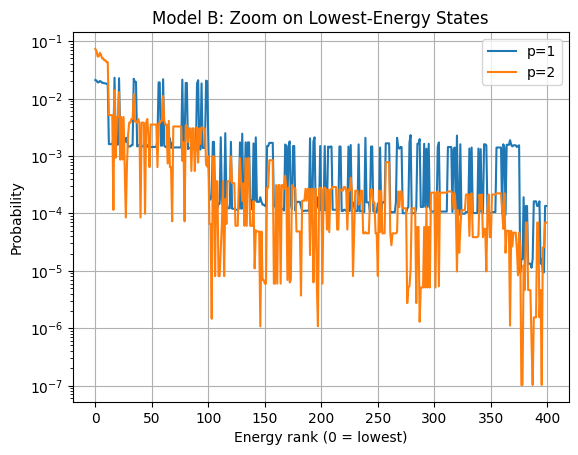

In [73]:
n = n_B
E = E_all_B

# sort states by increasing energy
idxs_by_energy = np.argsort(E)
ranks = np.arange(len(E))  # 0..2^n - 1

probs_p1_sorted = probs_p1[idxs_by_energy]
probs_p2_sorted = probs_p2[idxs_by_energy]
energies_sorted = E[idxs_by_energy]


kmax = 400
plt.figure()
plt.semilogy(ranks[:kmax], probs_p1_sorted[:kmax], label="p=1")
plt.semilogy(ranks[:kmax], probs_p2_sorted[:kmax], label="p=2")
plt.xlabel("Energy rank (0 = lowest)")
plt.ylabel("Probability")
plt.title("Model B: Zoom on Lowest-Energy States")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
ground_ranks = np.where(np.isclose(energies_sorted, E_min))[0]
print("Energy ranks of exact ground states:", ground_ranks)

Energy ranks of exact ground states: [0]


In [39]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
import numpy as np
import time

# 3-qubit line graph: edges (0,1) and (1,2)
# MaxCut Hamiltonian: H = 1/2 (I - Z0Z1) + 1/2 (I - Z1Z2)
paulis = ["ZZI", "IZZ", "III"]   # Z0Z1, Z1Z2, I
coeffs = [-0.5, -0.5, 1.0]       # -1/2 Z0Z1 -1/2 Z1Z2 + 1*I
H_3q = SparsePauliOp(paulis, coeffs=np.array(coeffs, dtype=complex))

print("3-qubit H:")
print("  num_qubits:", H_3q.num_qubits)
print("  num_terms :", len(H_3q))

sampler = StatevectorSampler(default_shots=1, seed=123)
optimizer = COBYLA(maxiter=50)

eval_log = []

def cb(eval_count, params, mean, metadata):
    eval_log.append((eval_count, float(mean)))
    print(f"callback eval {eval_count}, energy={mean}")

qaoa_3q = QAOA(
    sampler=sampler,
    optimizer=optimizer,
    reps=1,
    callback=cb
)

t0 = time.perf_counter()
result_3q = qaoa_3q.compute_minimum_eigenvalue(operator=H_3q)
t1 = time.perf_counter()

print("\nQiskit QAOA 3-qubit demo:")
print("  total time     :", t1 - t0, "seconds")
print("  num evaluations:", len(eval_log))
print("  best energy    :", result_3q.eigenvalue.real)
print("  optimal params :", result_3q.optimal_point)

3-qubit H:
  num_qubits: 3
  num_terms : 3
callback eval 1, energy=2.0
callback eval 2, energy=2.0
callback eval 3, energy=2.0
callback eval 4, energy=2.0
callback eval 5, energy=2.0
callback eval 6, energy=2.0
callback eval 7, energy=2.0

Qiskit QAOA 3-qubit demo:
  total time     : 0.16726951400050893 seconds
  num evaluations: 7
  best energy    : 2.0
  optimal params : [2.89946218 6.20289459]


/home/dylan/6240/.venv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/dylan/6240/.venv/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/home/dylan/6240/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [40]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

def qubo_to_pauli_op(Q: np.ndarray, const_offset: float = 0.0):
    """
    Convert QUBO E(x) = x^T Q x + const_offset with x in {0,1}^n
    into a cost Hamiltonian H_cost as a SparsePauliOp, using:
        x_i -> (I - Z_i)/2.

    Assumes Q is the full symmetric QUBO matrix you use in E = x^T Q x.
    """
    n = Q.shape[0]
    assert Q.shape == (n, n)
    # symmetrize Q to be safe
    Qs = 0.5 * (Q + Q.T)

    paulis = []
    coeffs = []
    C = const_offset  # track the constant shift

    def add_Z_term(i_list, coeff):
        """
        Add coeff * (prod_{i in i_list} Z_i) to the operator.
        i_list: list of qubit indices (0-based, LSBit convention).
        """
        nonlocal paulis, coeffs
        if abs(coeff) < 1e-12:
            return
        s = ['I'] * n
        # Qiskit: rightmost char is qubit 0
        for i in i_list:
            s[n - 1 - i] = 'Z'
        paulis.append(''.join(s))
        coeffs.append(coeff)

    # Diagonal terms: Q_ii x_i
    # Q_ii x_i = Q_ii * (I - Z_i)/2
    for i in range(n):
        Qi = Qs[i, i]
        if abs(Qi) > 1e-12:
            C += Qi * 0.5           # + (Qii/2) * I
            add_Z_term([i], -Qi * 0.5)  # - (Qii/2) * Z_i

    # Off-diagonal terms: 2 * Q_ij x_i x_j  for i<j
    # 2 Q_ij x_i x_j = (Qij/2) * (1 - Z_i - Z_j + Z_i Z_j)
    for i in range(n):
        for j in range(i + 1, n):
            Qij = Qs[i, j]
            if abs(Qij) < 1e-12:
                continue

            C += (Qij / 2.0)                 # + (Qij/2) * I
            add_Z_term([i], -(Qij / 2.0))    # - (Qij/2) * Z_i
            add_Z_term([j], -(Qij / 2.0))    # - (Qij/2) * Z_j
            add_Z_term([i, j], (Qij / 2.0))  # + (Qij/2) * Z_i Z_j

    if not paulis:
        paulis = ['I' * n]
        coeffs = [0.0]

    H_op = SparsePauliOp(paulis, coeffs=np.array(coeffs, dtype=complex))
    return H_op, C


def pretty_print_sparse_pauli(op: SparsePauliOp):
    """
    Print SparsePauliOp as H = sum coeff * (Z[i] Z[j] ...),
    assuming only I/Z terms (true for this cost Hamiltonian).
    """
    n = op.num_qubits
    print("H =")
    for pauli, coeff in zip(op.paulis, op.coeffs):
        c = complex(coeff)
        if abs(c) < 1e-12:
            continue

        s = pauli.to_label()  # e.g. 'IIIIIIIIIIZ'
        z_positions = []
        # reversed so idx corresponds to qubit index (LSB = qubit 0)
        for idx, ch in enumerate(reversed(s)):
            if ch == 'Z':
                z_positions.append(idx)

        if not z_positions:
            term_str = "I"
        else:
            zs = " ".join(f"Z[{i}]" for i in z_positions)
            term_str = zs

        print(f"  ({c.real:+.3f}{c.imag:+.3f}j) * {term_str}")


In [41]:
# Build Hamiltonian for your LUT-mapping QUBO (Model B)
H_cost_op_B, C_B = qubo_to_pauli_op(Q_B, const_offset=const_B)

print("Model B Hamiltonian:")
print("  num_qubits:", H_cost_op_B.num_qubits)
print("  num_terms :", len(H_cost_op_B))

# Optional: simplify to merge identical Pauli strings
H_cost_op_B_simplified = H_cost_op_B.simplify(atol=1e-12)
print("After simplify:")
print("  num_terms :", len(H_cost_op_B_simplified))

# Optional: inspect terms
pretty_print_sparse_pauli(H_cost_op_B_simplified)
print("Constant energy shift C_B:", C_B)

### RUN QAOA for QUBO
sampler = StatevectorSampler(default_shots=1, seed=123)
optimizer = COBYLA(maxiter=50)

eval_log = []

def cb(eval_count, params, mean, metadata):
    eval_log.append((eval_count, float(mean)))
    print(f"callback eval {eval_count}, energy={mean}")
    
qaoa_b11 = QAOA(
    sampler=sampler,
    optimizer=optimizer,
    reps=1,
    callback=cb
)

t0 = time.perf_counter()
# result_3q = qaoa_b11.compute_minimum_eigenvalue(operator=H_cost_op_B_simplified)
t1 = time.perf_counter()    

Model B Hamiltonian:
  num_qubits: 11
  num_terms : 26
After simplify:
  num_terms : 14
H =
  (+0.500+0.000j) * Z[0]
  (+0.500+0.000j) * Z[1]
  (+0.500+0.000j) * Z[2]
  (+0.500+0.000j) * Z[3]
  (-0.050+0.000j) * Z[4]
  (-0.100+0.000j) * Z[6]
  (-0.600+0.000j) * Z[8]
  (-0.600+0.000j) * Z[9]
  (-0.500+0.000j) * Z[10]
  (+0.500+0.000j) * Z[4] Z[5]
  (+0.500+0.000j) * Z[6] Z[7]
  (+0.500+0.000j) * Z[8] Z[9]
  (+0.500+0.000j) * Z[8] Z[10]
  (+0.500+0.000j) * Z[9] Z[10]
Constant energy shift C_B: 4.35


In [42]:
import numpy as np
from scipy.optimize import minimize

def optimize_qaoa_with_trace(E_all, p, theta0=None, maxiter=80, method="Nelder-Mead"):
    """
    Run classical optimization of QAOA angles and record all theta values.
    Returns:
      res           - scipy OptimizeResult
      theta_history - np.array of shape (num_evals, 2p)
    """
    n_params = 2 * p
    if theta0 is None:
        theta0 = np.random.uniform(0, 2*np.pi, size=n_params)

    theta_history = []

    def objective(theta):
        theta_history.append(theta.copy())
        return qaoa_energy_p(theta, E_all, p)

    res = minimize(
        objective,
        theta0,
        method=method,
        options={"maxiter": maxiter}
    )

    return res, np.array(theta_history)

# run it for Model B, p=1
p1 = 1
res_p1_B, theta_hist_p1_B = optimize_qaoa_with_trace(E_all_B, p=p1, maxiter=80)

print("p=1 best energy:", res_p1_B.fun)
print("p=1 best theta:", res_p1_B.x)

p=1 best energy: 1.9750937931874173
p=1 best theta: [4.3192865 3.6919575]


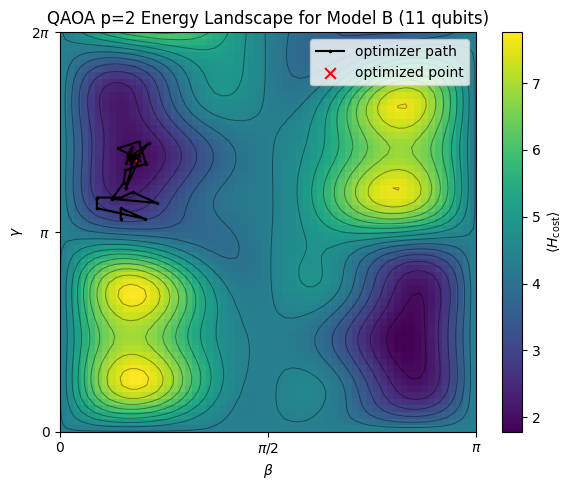

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# --- build p=1 energy grid ---
n_gamma = 60
n_beta  = 60
gamma_vals = np.linspace(0.0, 2.0*np.pi, n_gamma)  # y-axis
beta_vals  = np.linspace(0.0, np.pi,       n_beta)  # x-axis

energy_grid_p1 = np.zeros((n_gamma, n_beta), dtype=float)

for i, gamma in enumerate(gamma_vals):
    for j, beta in enumerate(beta_vals):
        theta = np.array([gamma, beta], dtype=float)
        energy_grid_p1[i, j] = qaoa_energy_p(theta, E_all_B, p=1)

# --- optimizer path & best point ---
# (make sure you've already run optimize_qaoa_with_trace to get these)
gammas_path_p1 = theta_hist_p1_B[:, 0]
betas_path_p1  = theta_hist_p1_B[:, 1]

# wrap into the same ranges we plot
gammas_path_p1 = np.mod(gammas_path_p1, 2.0*np.pi)
betas_path_p1  = np.mod(betas_path_p1,  np.pi)

gamma_best_p1  = np.mod(res_p1_B.x[0], 2.0*np.pi)
beta_best_p1   = np.mod(res_p1_B.x[1],  np.pi)

plt.figure(figsize=(6, 5))

# heatmap
im = plt.imshow(
    energy_grid_p1,
    origin="lower",
    aspect="auto",
    extent=[beta_vals[0], beta_vals[-1], gamma_vals[0], gamma_vals[-1]]
)

# contours
plt.contour(
    beta_vals,
    gamma_vals,
    energy_grid_p1,
    levels=15,
    colors='k',
    alpha=0.4,
    linewidths=0.7,
)

plt.colorbar(im, label=r"$\langle H_{\mathrm{cost}} \rangle$")

# optimizer path (black so it shows up everywhere)
plt.plot(
    betas_path_p1,
    gammas_path_p1,
    "k.-",
    markersize=3,
    linewidth=1.5,
    label="optimizer path",
)

# final optimized point
plt.scatter(
    [beta_best_p1],
    [gamma_best_p1],
    color="red",
    marker="x",
    s=60,
    label="optimized point",
)

plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.title("QAOA p=2 Energy Landscape for Model B (11 qubits)")
plt.legend(loc="upper right")

# force axes to match heatmap extent (remove white strip)
plt.xlim(beta_vals[0], beta_vals[-1])
plt.ylim(gamma_vals[0], gamma_vals[-1])

# nicer tick labels
plt.xticks([0, np.pi/2, np.pi], [r"0", r"$\pi/2$", r"$\pi$"])
plt.yticks([0, np.pi, 2*np.pi], [r"0", r"$\pi$", r"$2\pi$"])

plt.tight_layout()
plt.show()


In [44]:
# Build E_all for a 4-qubit half-adder constraint: (a,b,s,c)
# Valid rows: 
# a b | s c
# 0 0 | 0 0
# 0 1 | 1 0
# 1 0 | 1 0
# 1 1 | 0 1

n = 4
N = 2**n

E_HA = np.ones(N, dtype=float)  # penalty 1 by default

def idx(a, b, s, c):
    return (a << 3) | (b << 2) | (s << 1) | c  # a b s c

valid_rows = [
    (0, 0, 0, 0),
    (0, 1, 1, 0),
    (1, 0, 1, 0),
    (1, 1, 0, 1),
]

for (a, b, s, c) in valid_rows:
    E_HA[idx(a,b,s,c)] = 0.0

print("E_HA shape:", E_HA.shape)
print("Number of ground states:", np.sum(E_HA == 0.0))


E_HA shape: (16,)
Number of ground states: 4


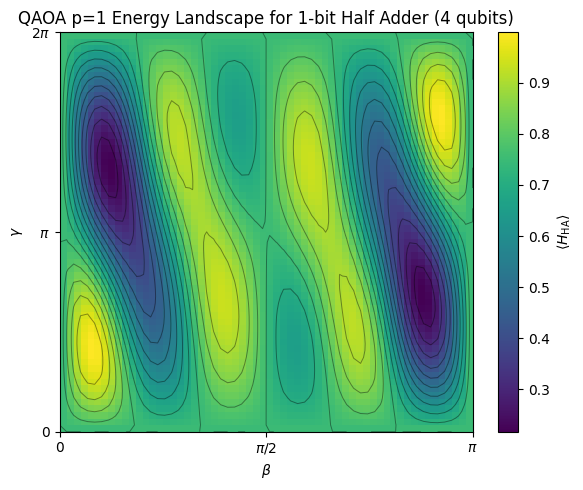

In [45]:
# p = 1 => parameter vector theta = [gamma, beta]
p = 1

n_gamma = 60
n_beta  = 60
gamma_vals = np.linspace(0.0, 2.0*np.pi, n_gamma)
beta_vals  = np.linspace(0.0, np.pi,       n_beta)

energy_grid_HA = np.zeros((n_gamma, n_beta), dtype=float)

for i, gamma in enumerate(gamma_vals):
    for j, beta in enumerate(beta_vals):
        theta = np.array([gamma, beta], dtype=float)
        energy_grid_HA[i, j] = qaoa_energy_p(theta, E_HA, p=1)

plt.figure(figsize=(6,5))

im = plt.imshow(
    energy_grid_HA,
    origin="lower",
    aspect="auto",
    extent=[beta_vals[0], beta_vals[-1], gamma_vals[0], gamma_vals[-1]]
)

# optional contours
plt.contour(
    beta_vals,
    gamma_vals,
    energy_grid_HA,
    levels=15,
    colors='k',
    alpha=0.4,
    linewidths=0.7,
)

plt.colorbar(im, label=r"$\langle H_{\mathrm{HA}} \rangle$")

plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.title("QAOA p=1 Energy Landscape for 1-bit Half Adder (4 qubits)")

plt.xticks([0, np.pi/2, np.pi], [r"0", r"$\pi/2$", r"$\pi$"])
plt.yticks([0, np.pi, 2*np.pi], [r"0", r"$\pi$", r"$2\pi$"])

plt.tight_layout()
plt.show()


In [46]:
# def bloch_demo():
#     from qutip import basis, sigmax, sigmaz, Bloch
#     import numpy as np
#     import matplotlib.pyplot as plt
#     import matplotlib
#     import ipywidgets as widgets
#     from ipywidgets import interact
#     from IPython.display import display, clear_output

#     # --- single-qubit toy QAOA: H_cost = Z, H_mix = X ---
#     H_cost = sigmaz()
#     H_mix  = sigmax()

#     ket0 = basis(2, 0)
#     ket1 = basis(2, 1)

#     # |+> = (|0> + |1>)/sqrt(2)
#     plus = (ket0 + ket1).unit()

#     # choose some QAOA angles (you can plug in your Model B p=1 best gamma,beta)
#     gamma = 1.3844  # example ~ from your heatmap
#     beta  = 2.6091

#     # --- set up Bloch sphere ---
#     b = Bloch()
#     b.fig = plt.figure(figsize=(3, 3))

#     # Optional: nicer labels similar to your earlier assignment
#     b.xlabel = ['$(|0\\rangle+|1\\rangle)/\\sqrt{2}$', '$(|0\\rangle-|1\\rangle)/\\sqrt{2}$']
#     b.ylabel = ['$(|0\\rangle+i|1\\rangle)/\\sqrt{2}$', '$(|0\\rangle-i|1\\rangle)/\\sqrt{2}$']
#     b.zlabel = ['$|0\\rangle$', '$|1\\rangle$']

#     matplotlib.rcParams.update({'font.size': 10})

#     # --- function that returns the QAOA state at "time" t in [0, 2] ---
#     # t in [0,1]: we interpolate cost rotation from 0 -> gamma
#     # t in [1,2]: we hold cost at gamma, interpolate mixer from 0 -> beta
#     def qaoa_state_onequbit(t):
#         t = float(t)
#         if t <= 1.0:
#             # partial cost evolution: U_C(t) = exp(-i * t*gamma * Z)
#             Uc = (-1j * t * gamma * H_cost).expm()
#             psi = Uc * plus
#         else:
#             # full cost, partial mixer
#             Uc  = (-1j * gamma * H_cost).expm()
#             Um  = (-1j * (t-1.0) * beta * H_mix).expm()
#             psi = Um * (Uc * plus)
#         return psi

#     # --- update function for the slider ---
#     def update_bloch(t=0.0):
#         psi = qaoa_state_onequbit(t)
#         b.clear()
#         b.add_states(psi)
#         b.vector_color = ['r']  # red state vector
#         b.show()

#     # interactive slider: t from 0 to 2
#     slider = widgets.FloatSlider(
#         value=0.0,
#         min=0.0,
#         max=2.0,
#         step=0.02,
#         description='QAOA step',
#         continuous_update=False
#     )

#     interactive_plot = widgets.interactive(update_bloch, t=slider)
#     display(interactive_plot)


FOR MODEL C BELOW

In [47]:
E_all_C = qubo_energy_all_bitstrings(Q_C, const_offset=const_C)
n_C = Q_C.shape[0]
print("Classical E_min_C:", E_all_C.min())

Classical E_min_C: 0.0


In [48]:
p1 = 1
res_p1_Ce, theta_hist_p1_Ce = optimize_qaoa_with_trace(E_all_B, p=p1, maxiter=80)

print("model c p=1 best energy:", res_p1_Ce.fun)
print("model c p=1 best theta:", res_p1_Ce.x)

model c p=1 best energy: 1.975093794584843
model c p=1 best theta: [4.31923594 0.55035566]


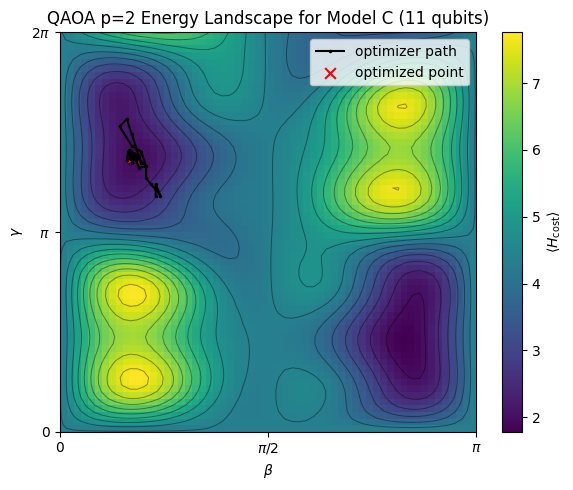

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# --- build p=1 energy grid ---
n_gamma = 60
n_beta  = 60
gamma_vals = np.linspace(0.0, 2.0*np.pi, n_gamma)  # y-axis
beta_vals  = np.linspace(0.0, np.pi,       n_beta)  # x-axis

energy_grid_p1 = np.zeros((n_gamma, n_beta), dtype=float)

for i, gamma in enumerate(gamma_vals):
    for j, beta in enumerate(beta_vals):
        theta = np.array([gamma, beta], dtype=float)
        energy_grid_p1[i, j] = qaoa_energy_p(theta, E_all_B, p=1)

# --- optimizer path & best point ---
# (make sure you've already run optimize_qaoa_with_trace to get these)
gammas_path_p1 = theta_hist_p1_Ce[:, 0]
betas_path_p1  = theta_hist_p1_Ce[:, 1]

# wrap into the same ranges we plot
gammas_path_p1 = np.mod(gammas_path_p1, 2.0*np.pi)
betas_path_p1  = np.mod(betas_path_p1,  np.pi)

gamma_best_p1  = np.mod(res_p1_Ce.x[0], 2.0*np.pi)
beta_best_p1   = np.mod(res_p1_Ce.x[1],  np.pi)

plt.figure(figsize=(6, 5))

# heatmap
im = plt.imshow(
    energy_grid_p1,
    origin="lower",
    aspect="auto",
    extent=[beta_vals[0], beta_vals[-1], gamma_vals[0], gamma_vals[-1]]
)

# contours
plt.contour(
    beta_vals,
    gamma_vals,
    energy_grid_p1,
    levels=15,
    colors='k',
    alpha=0.4,
    linewidths=0.7,
)

plt.colorbar(im, label=r"$\langle H_{\mathrm{cost}} \rangle$")

# optimizer path (black so it shows up everywhere)
plt.plot(
    betas_path_p1,
    gammas_path_p1,
    "k.-",
    markersize=3,
    linewidth=1.5,
    label="optimizer path",
)

# final optimized point
plt.scatter(
    [beta_best_p1],
    [gamma_best_p1],
    color="red",
    marker="x",
    s=60,
    label="optimized point",
)

plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.title("QAOA p=2 Energy Landscape for Model C (11 qubits)")
plt.legend(loc="upper right")

# force axes to match heatmap extent (remove white strip)
plt.xlim(beta_vals[0], beta_vals[-1])
plt.ylim(gamma_vals[0], gamma_vals[-1])

# nicer tick labels
plt.xticks([0, np.pi/2, np.pi], [r"0", r"$\pi/2$", r"$\pi$"])
plt.yticks([0, np.pi, 2*np.pi], [r"0", r"$\pi$", r"$2\pi$"])

plt.tight_layout()
plt.show()

In [50]:
# p=1
res_p1_C, gammas_p1_C, betas_p1_C, psi_p1_C, probs_p1_C = run_qaoa_optimization(
    E_all_C, p=1, theta0=None, maxiter=100, method="Nelder-Mead"
)

# p=2 (seed from p=1)
theta0_p2_C = np.array(
    [gammas_p1_C[0], gammas_p1_C[0], betas_p1_C[0], betas_p1_C[0]],
    dtype=float
)
res_p2_C, gammas_p2_C, betas_p2_C, psi_p2_C, probs_p2_C = run_qaoa_optimization(
    E_all_C, p=2, theta0=theta0_p2_C, maxiter=200, method="Nelder-Mead"
)

Optimization terminated successfully.
         Current function value: 1.515758
         Iterations: 44
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 0.626645
         Iterations: 132
         Function evaluations: 227


In [51]:
E_min_C = E_all_C.min()
ground_idxs_C = np.where(np.isclose(E_all_C, E_min_C))[0]
print("Model C ground states:", len(ground_idxs_C))

overlap_p1_C = probs_p1_C[ground_idxs_C].sum()
overlap_p2_C = probs_p2_C[ground_idxs_C].sum()

print("p=1 ground overlap:", overlap_p1_C)
print("p=2 ground overlap:", overlap_p2_C)

Model C ground states: 10
p=1 ground overlap: 0.2042076261075467
p=2 ground overlap: 0.5130711621212124


In [52]:
# If you want to list them:
print("\nGround-state bitstrings:")
for idx in ground_idxs_C:
    print(idx_to_bits(idx, n_C), "prob =", probs_p1_C[idx])


Ground-state bitstrings:
00110011111 prob = 0.01992702285669561
00110101111 prob = 0.01992702285669561
01001011111 prob = 0.020759734360574905
01001101111 prob = 0.020759734360574905
01010011111 prob = 0.020328660737963966
01010101111 prob = 0.020328660737963966
10001011111 prob = 0.020759734360574905
10001101111 prob = 0.020759734360574905
10010011111 prob = 0.020328660737963966
10010101111 prob = 0.020328660737963966


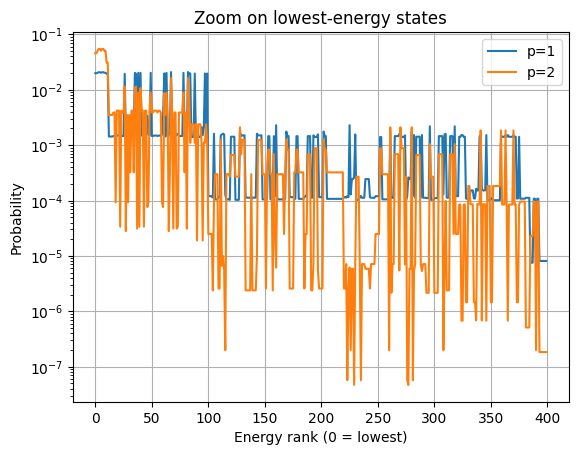

In [ ]:
n = n_C
E = E_all_C

# sort states by increasing energy
idxs_by_energy = np.argsort(E)
ranks = np.arange(len(E))  # 0..2^n - 1

probs_p1_sorted = probs_p1_C[idxs_by_energy]
probs_p2_sorted = probs_p2_C[idxs_by_energy]
energies_sorted = E[idxs_by_energy]


kmax = 400
plt.figure()
plt.semilogy(ranks[:kmax], probs_p1_sorted[:kmax], label="p=1")
plt.semilogy(ranks[:kmax], probs_p2_sorted[:kmax], label="p=2")
plt.xlabel("Energy rank (0 = lowest)")
plt.ylabel("Probability")
plt.title("Model B: Zoom on Lowest-Energy States")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
p3 = 3

# simple warm-start: tile p=2 solution into p=3
theta0_p3_C = np.concatenate([
    gammas_p2_C,
    [gammas_p2_C[-1]],  # repeat last gamma
    betas_p2_C,
    [betas_p2_C[-1]]    # repeat last beta
])

res_p3_C, gammas_p3_C, betas_p3_C, psi_p3_C, probs_p3_C = run_qaoa_optimization(
    E_all_C, p=p3, theta0=theta0_p3_C, maxiter=300, method="Nelder-Mead"
)

print("p=3 best energy:", res_p3_C.fun)


p=3 best energy: 0.33728065037316624


/tmp/ipykernel_61619/1408361257.py:51: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(


In [55]:
E_min_C = E_all_C.min()
ground_idxs_C = np.where(np.isclose(E_all_C, E_min_C))[0]

def overlap(probs):
    return probs[ground_idxs_C].sum()

print("Ground-space overlaps (Model C):")
print("  p=1:", overlap(probs_p1_C))
print("  p=2:", overlap(probs_p2_C))
print("  p=3:", overlap(probs_p3_C))


Ground-space overlaps (Model C):
  p=1: 0.2042076261075467
  p=2: 0.5130711621212124
  p=3: 0.556191432458484


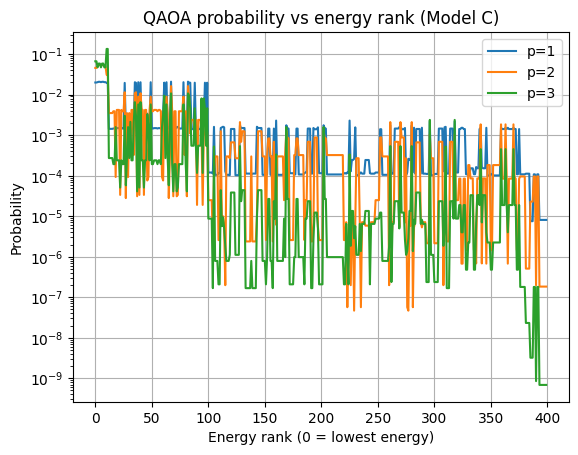

In [76]:
import matplotlib.pyplot as plt

n_C = int(np.log2(len(E_all_C)))
E = E_all_C
idxs_by_energy = np.argsort(E)
ranks = np.arange(len(E))

probs_p1_sorted = probs_p1_C[idxs_by_energy]
probs_p2_sorted = probs_p2_C[idxs_by_energy]
probs_p3_sorted = probs_p3_C[idxs_by_energy]

kmax = 400# zoom on low-energy states

plt.figure()
plt.semilogy(ranks[:kmax], probs_p1_sorted[:kmax], label="p=1")
plt.semilogy(ranks[:kmax], probs_p2_sorted[:kmax], label="p=2")
plt.semilogy(ranks[:kmax], probs_p3_sorted[:kmax], label="p=3")
plt.xlabel("Energy rank (0 = lowest energy)")
plt.ylabel("Probability")
plt.title("QAOA probability vs energy rank (Model C)")
plt.legend()
plt.grid(True)
plt.show()


2 BIT RIPPLE CARRY ADDER BELOW

In [57]:
# ---------- Build a 2-bit ripple-carry adder circuit ----------

def make_2bit_ripple_adder(k: int = 4) -> Circuit:
    """
    Construct a 2-bit ripple-carry adder using two 1-bit full adders.

      inputs:  a0, b0, a1, b1, cin
      outputs: sum0, sum1, cout

    Stage 0 (LSB):
        s1_0   = a0 XOR b0
        sum0   = s1_0 XOR cin

        c1_0   = a0 AND b0
        c2_0   = a0 AND cin
        c3_0   = b0 AND cin

        t1_0   = c1_0 OR c2_0
        cout0  = t1_0 OR c3_0   # carry into MSB stage

    Stage 1 (MSB):
        s1_1   = a1 XOR b1
        sum1   = s1_1 XOR cout0

        c1_1   = a1 AND b1
        c2_1   = a1 AND cout0
        c3_1   = b1 AND cout0

        t1_1   = c1_1 OR c2_1
        cout   = t1_1 OR c3_1   # final carry-out
    """
    c = Circuit("adder2bit", k=k)

    # Primary inputs
    c.add_pi("a0")
    c.add_pi("b0")
    c.add_pi("a1")
    c.add_pi("b1")
    c.add_pi("cin")

    # ----- Stage 0: LSB full adder -----
    c.add_gate("s1_0",  "XOR", ["a0", "b0"])
    c.add_gate("sum0",  "XOR", ["s1_0", "cin"])

    c.add_gate("c1_0",  "AND", ["a0", "b0"])
    c.add_gate("c2_0",  "AND", ["a0", "cin"])
    c.add_gate("c3_0",  "AND", ["b0", "cin"])

    c.add_gate("t1_0",  "OR",  ["c1_0", "c2_0"])
    c.add_gate("cout0", "OR",  ["t1_0", "c3_0"])  # intermediate carry

    # ----- Stage 1: MSB full adder -----
    c.add_gate("s1_1",  "XOR", ["a1", "b1"])
    c.add_gate("sum1",  "XOR", ["s1_1", "cout0"])

    c.add_gate("c1_1",  "AND", ["a1", "b1"])
    c.add_gate("c2_1",  "AND", ["a1", "cout0"])
    c.add_gate("c3_1",  "AND", ["b1", "cout0"])

    c.add_gate("t1_1",  "OR",  ["c1_1", "c2_1"])
    c.add_gate("cout",  "OR",  ["t1_1", "c3_1"])

    # Mark outputs
    c.add_output("sum0")
    c.add_output("sum1")
    c.add_output("cout")

    return c

# Quick sanity check
rca2 = make_2bit_ripple_adder()
print(rca2)
print("Topo order:", rca2.topo_order())
# rows = truth_table(full_adder)

Circuit(name='adder2bit', k=4, nodes=19)
Topo order: ['a0', 'b0', 'a1', 'b1', 'cin', 's1_0', 'c1_0', 's1_1', 'c1_1', 'c2_0', 'c3_0', 'sum0', 't1_0', 'cout0', 'sum1', 'c2_1', 'c3_1', 't1_1', 'cout']


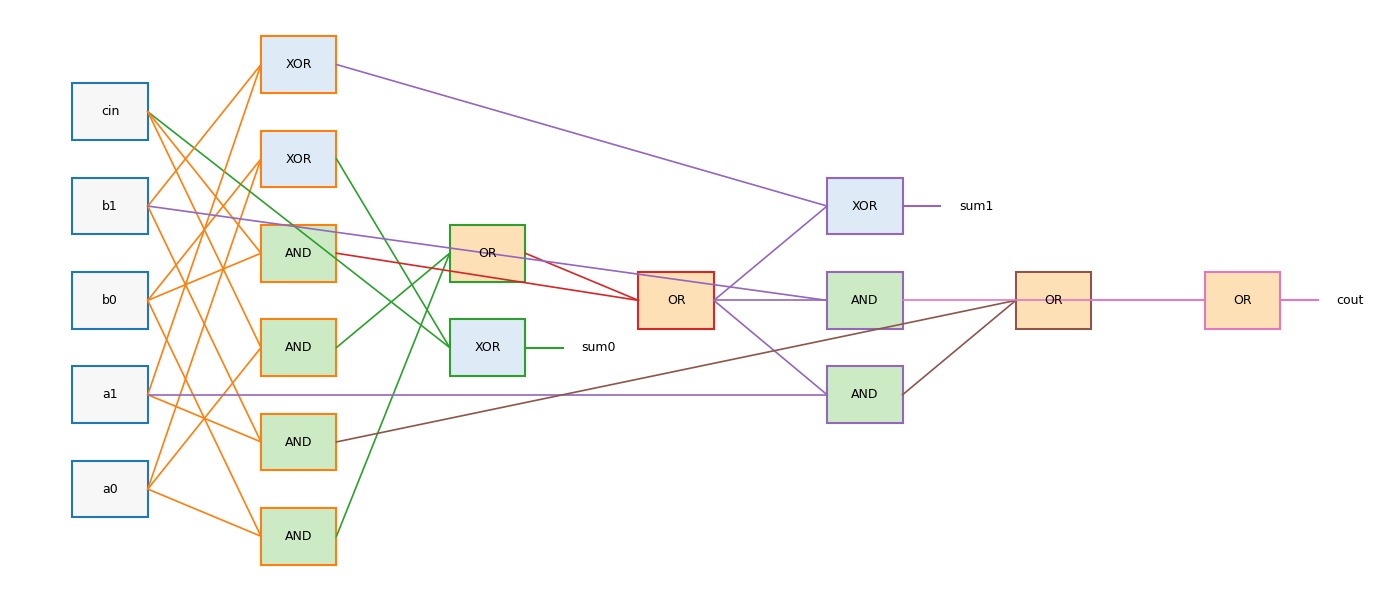

In [58]:
draw_logic_circuit(rca2, filename="ripple_carry_circuit.png")

In [59]:
Q_rca, cuts_rca, var_index_rca, index_to_var_rca, const_rca = build_model_C_qubo(rca2, k=4,
                                                                       penalty_exact=1.0,
                                                                       lam_dup=0.2)

Total QUBO variables (cut choices): 28


In [60]:
def qubo_energy_single(x_bits, Q, const_offset=0.0):
    """
    Compute E(x) = x^T Q x + const for a single bitvector x_bits in {0,1}^n.
    x_bits: 1D np.array of shape (n,) with 0/1.
    """
    x = x_bits.astype(float)
    return float(x @ Q @ x + const_offset)


def hill_climb_1flip(Q, const_offset=0.0, max_steps=1000):
    """
    Simple 1-bit-flip hill climber:
    - start from random x
    - repeatedly flip the single bit that gives the largest decrease in energy
    - stop when no improving 1-bit flip exists
    Returns (x_local_min, E_local_min).
    """
    n = Q.shape[0]
    x = np.random.randint(0, 2, size=n, dtype=int)
    E = qubo_energy_single(x, Q, const_offset)

    for _ in range(max_steps):
        best_delta = 0.0
        best_bit = None

        # try flipping each bit
        for i in range(n):
            x_trial = x.copy()
            x_trial[i] ^= 1
            E_trial = qubo_energy_single(x_trial, Q, const_offset)
            delta = E_trial - E
            if delta < best_delta:
                best_delta = delta
                best_bit = i

        if best_bit is None:
            # no improving move => local minimum
            break

        # apply best move
        x[best_bit] ^= 1
        E += best_delta

    return x, E


def multi_start_hill_climb(Q, const_offset=0.0, n_restarts=100):
    """
    Run hill climbing multiple times from random starts.
    Return a list of (x, E) local minima found.
    """
    minima = []
    seen = set()

    for _ in range(n_restarts):
        x_local, E_local = hill_climb_1flip(Q, const_offset)
        key = tuple(x_local.tolist())
        if key not in seen:
            seen.add(key)
            minima.append((x_local, E_local))

    # sort by energy
    minima.sort(key=lambda t: t[1])
    return minima


In [61]:
local_minima = multi_start_hill_climb(Q_rca, const_offset=const_rca, n_restarts=400)
print("Found", len(local_minima), "distinct local minima.")
# for i, (x_min, E_min) in enumerate(local_minima[:10]):
#     print(i, "E =", E_min)


Found 286 distinct local minima.


In [62]:
x_best_rca2, E_best_rca2 = local_minima[0]
print("Best local min energy (full RCA2):", E_best_rca2)
print("Best x shape:", x_best_rca2.shape)


Best local min energy (full RCA2): 0.0
Best x shape: (28,)


In [63]:
import numpy as np

def reduce_qubo_around_baseline(Q, const_offset, x_fix, free_indices):
    """
    Given full Q (n x n), const_offset, and a fixed 0/1 baseline x_fix (length n),
    construct a reduced QUBO over the subset of variables in free_indices.

    Let x = (y, f) where y are free vars, f are fixed to x_fix.
    Then E(x) = x^T Q x + const_offset  ->  E(y) = y^T Q_eff y + const_eff,
    with Q_eff symmetric (includes diagonal from linear terms).

    Returns:
        Q_eff (m x m), const_eff, free_indices_array, fixed_indices_array
    """
    n = Q.shape[0]
    free_indices = np.array(free_indices, dtype=int)
    m = free_indices.size

    # Fixed indices are all others
    mask = np.ones(n, dtype=bool)
    mask[free_indices] = False
    fixed_indices = np.where(mask)[0]

    # Partition Q
    Qyy = Q[np.ix_(free_indices, free_indices)]      # m x m
    Qyf = Q[np.ix_(free_indices, fixed_indices)]     # m x (n-m)
    Qff = Q[np.ix_(fixed_indices, fixed_indices)]    # (n-m) x (n-m)

    f = x_fix[fixed_indices].astype(float)           # (n-m,)

    # Constant part from fixed bits
    const_eff = const_offset + float(f @ Qff @ f)

    # Linear terms from interaction between y and fixed f:
    # E = y^T Qyy y + 2 y^T Qyf f + f^T Qff f + const_offset
    #  => linear term l = 2 Qyf f, and we fold l_i y_i into diag since y_i^2 = y_i
    l = 2.0 * (Qyf @ f)                              # shape (m,)

    Q_eff = Qyy.copy()
    Q_eff[np.arange(m), np.arange(m)] += l

    return Q_eff, const_eff, free_indices, fixed_indices


In [64]:
n_rca2 = Q_rca.shape[0]
m = 20  # number of free variables for QAOA

# simplest: choose the first m variables as "free"
# (you can later change this to focus on specific nodes)
free_indices = list(range(m))

Q_rca2_eff, const_rca2_eff, free_idx_arr, fixed_idx_arr = reduce_qubo_around_baseline(
    Q_rca, const_rca, x_best_rca2, free_indices
)

print("Reduced QUBO size:", Q_rca2_eff.shape)
print("Effective constant offset:", const_rca2_eff)


Reduced QUBO size: (20, 20)
Effective constant offset: 12.0


In [65]:
# E_all_rca2_eff: energies for all y in {0,1}^m under reduced QUBO
E_all_rca2_eff = qubo_energy_all_bitstrings(Q_rca2_eff, const_offset=const_rca2_eff)
print("Reduced problem: num states =", len(E_all_rca2_eff))
print("Min energy:", E_all_rca2_eff.min())


Reduced problem: num states = 1048576
Min energy: 0.0


In [66]:
# Try p = 1, 2 for the reduced RCA2 slice
p_eff = 1  # you can also try 1, 3, 4 etc

res_rca2_eff, gammas_rca2_eff, betas_rca2_eff, psi_rca2_eff, probs_rca2_eff = \
    run_qaoa_optimization(
        E_all_rca2_eff,
        p=p_eff,
        theta0=None,
        maxiter=80,
        method="Nelder-Mead"
    )

print("Reduced RCA2 QAOA (p={}): best energy =".format(p_eff), res_rca2_eff.fun)
print("gammas:", gammas_rca2_eff)
print("betas:", betas_rca2_eff)


KeyboardInterrupt: 

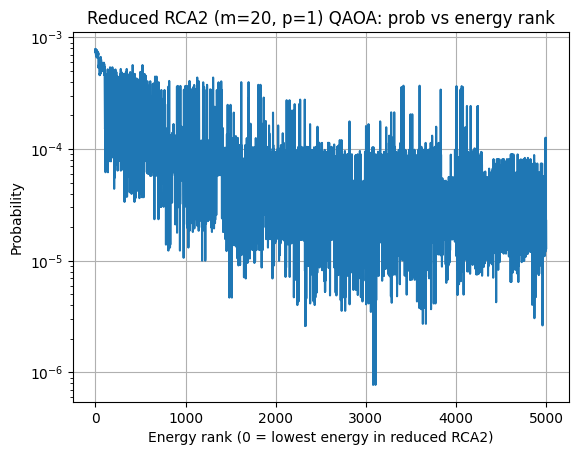

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

E = E_all_rca2_eff
probs = probs_rca2_eff

idxs_by_energy = np.argsort(E)
ranks = np.arange(len(E))

E_sorted = E[idxs_by_energy]
probs_sorted = probs[idxs_by_energy]

kmax = 5000  # zoom near the low-energy part

plt.figure()
plt.semilogy(ranks[:kmax], probs_sorted[:kmax])
plt.xlabel("Energy rank (0 = lowest energy in reduced RCA2)")
plt.ylabel("Probability")
plt.title(f"Reduced RCA2 (m={m}, p={p_eff}) QAOA: prob vs energy rank")
plt.grid(True)
plt.show()


In [ ]:
E_min_eff = E.min()
ground_idxs_eff = np.where(np.isclose(E, E_min_eff))[0]
print("Reduced RCA2: number of minimizers:", len(ground_idxs_eff))

for idx in ground_idxs_eff:
    bits = idx_to_bits(idx, m)  # same helper you used before
    print("y =", bits, "E =", E[idx], "prob =", probs[idx])


Reduced RCA2: number of minimizers: 6
y = 01100010100101111111 E = 0.0 prob = 0.0007522781456745245
y = 01100010100110111111 E = 0.0 prob = 0.0007522781456745245
y = 01100010101001111111 E = 0.0 prob = 0.0007354272883822411
y = 01100010101010111111 E = 0.0 prob = 0.0007354272883822411
y = 01100011000101111111 E = 0.0 prob = 0.0007884273373147499
y = 01100011000110111111 E = 0.0 prob = 0.0007884273373147499


In [ ]:
def overlap(probs, ground_idxs):
    return probs[ground_idxs].sum()

print("Ground-space overlap (reduced RCA2, p={}):".format(p_eff),
      overlap(probs, ground_idxs_eff))


Ground-space overlap (reduced RCA2, p=1): 0.004552265542743031


In [ ]:
n_rca2 = Q_rca.shape[0]   # should be 28
m = 20                     # number of free variables per slice
T = 3                      # number of random slices (3–4 is good)

rng = np.random.default_rng(123)  # fixed seed for reproducibility

# Generate T random subsets of size m (no replacement *within* each subset)
free_indices_list = []
for t in range(T):
    free_idx = rng.choice(n_rca2, size=m, replace=False)
    free_indices_list.append(np.sort(free_idx))  # sort just for readability

for t, fi in enumerate(free_indices_list):
    print(f"Slice {t}: free indices = {fi}")


Slice 0: free indices = [ 0  2  3  5  6  9 10 11 12 14 16 17 18 19 20 21 22 23 24 26]
Slice 1: free indices = [ 0  1  2  3  4  6  7  9 10 11 12 14 15 17 18 19 20 21 24 27]
Slice 2: free indices = [ 0  3  4  5  6  8 10 12 13 14 16 17 18 19 22 23 24 25 26 27]



=== Slice 0 with free vars 20 ===
  Reduced QUBO size: (20, 20)
  Num states in slice: 1048576
  Min energy in slice: 0.0


/tmp/ipykernel_1898/1408361257.py:51: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(


  QAOA best energy (p=2): 4.546849403204494


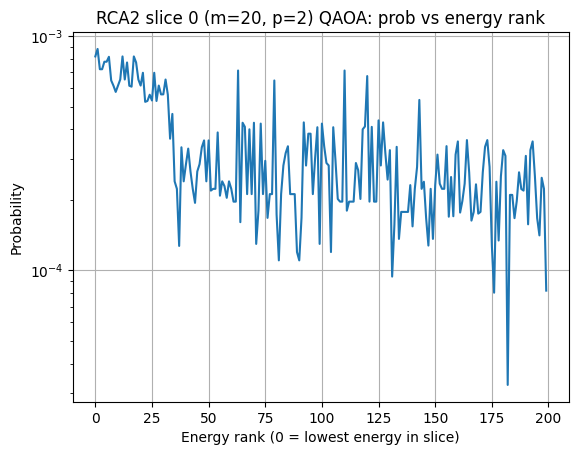


=== Slice 1 with free vars 20 ===
  Reduced QUBO size: (20, 20)
  Num states in slice: 1048576
  Min energy in slice: 0.0
  QAOA best energy (p=2): 4.522426760215187


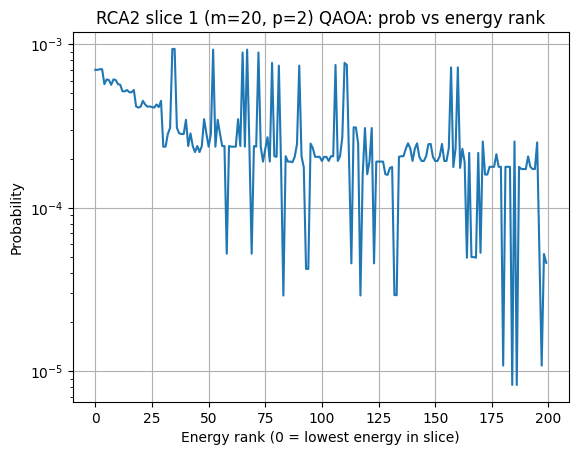


=== Slice 2 with free vars 20 ===
  Reduced QUBO size: (20, 20)
  Num states in slice: 1048576
  Min energy in slice: 0.0
  QAOA best energy (p=2): 4.154658827290913


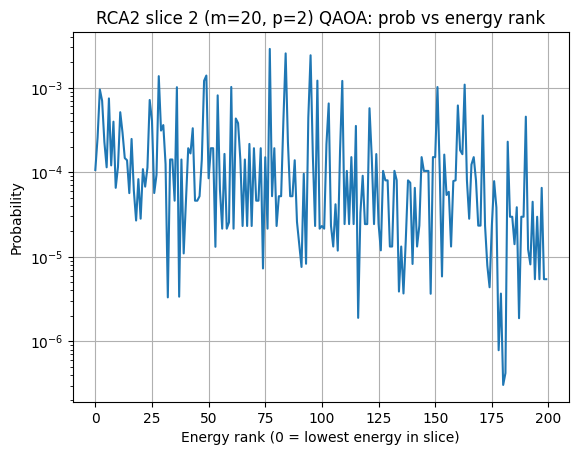

In [ ]:
results_slices = []

p_eff = 2      # QAOA depth for the 20-var slice (you can try p=1 if runtime is tight)
maxiter = 60   # keep modest so it finishes in time

for t, free_indices in enumerate(free_indices_list):
    print(f"\n=== Slice {t} with free vars {len(free_indices)} ===")
    
    # 1) Reduce QUBO around baseline x_best_rca2
    Q_eff, const_eff, free_idx_arr, fixed_idx_arr = reduce_qubo_around_baseline(
        Q_rca, const_rca, x_best_rca2, free_indices
    )
    m_eff = Q_eff.shape[0]
    print("  Reduced QUBO size:", Q_eff.shape)
    
    # 2) Compute all energies for this slice
    E_all_eff = qubo_energy_all_bitstrings(Q_eff, const_offset=const_eff)
    print("  Num states in slice:", len(E_all_eff))
    print("  Min energy in slice:", E_all_eff.min())
    
    # 3) Run your manual QAOA
    res_eff, gammas_eff, betas_eff, psi_eff, probs_eff = run_qaoa_optimization(
        E_all_eff,
        p=p_eff,
        theta0=None,
        maxiter=maxiter,
        method="Nelder-Mead"
    )
    print(f"  QAOA best energy (p={p_eff}):", res_eff.fun)
    
    # 4) Sort prob by energy rank
    idxs_by_energy = np.argsort(E_all_eff)
    ranks = np.arange(len(E_all_eff))
    E_sorted = E_all_eff[idxs_by_energy]
    probs_sorted = probs_eff[idxs_by_energy]
    
    # store for later if you want to compare across slices
    results_slices.append({
        "free_indices": free_indices,
        "Q_eff": Q_eff,
        "const_eff": const_eff,
        "E_all_eff": E_all_eff,
        "gammas": gammas_eff,
        "betas": betas_eff,
        "probs": probs_eff,
        "E_sorted": E_sorted,
        "probs_sorted": probs_sorted,
    })
    
    # 5) Plot probability vs energy rank for this slice
    kmax = min(200, len(E_sorted))  # zoom region
    plt.figure()
    plt.semilogy(ranks[:kmax], probs_sorted[:kmax])
    plt.xlabel("Energy rank (0 = lowest energy in slice)")
    plt.ylabel("Probability")
    plt.title(f"RCA2 slice {t} (m={m_eff}, p={p_eff}) QAOA: prob vs energy rank")
    plt.grid(True)
    plt.show()


In [ ]:
for t, res in enumerate(results_slices):
    E = res["E_all_eff"]
    probs = res["probs"]
    E_min = E.min()
    ground_idxs = np.where(np.isclose(E, E_min))[0]
    overlap = probs[ground_idxs].sum()
    print(f"Slice {t}: min E = {E_min}, #ground states = {len(ground_idxs)}, overlap = {overlap:.3f}")


Slice 0: min E = 0.0, #ground states = 1, overlap = 0.000
Slice 1: min E = 0.0, #ground states = 6, overlap = 0.005
Slice 2: min E = 0.0, #ground states = 1, overlap = 0.001
